In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline

In [ ]:
!pip install datasets transformers

In [6]:

cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')
# Max emotions represents the total emotions generated for each comment (ie our max)
# Min emotions represents the minimum number of emotions we accept for each comment (threshold)
max_emotions = 6
min_emotions = 3
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=max_emotions)

test_comment_1 = cmv_df.iloc[0]['Review-Body']


sentences = [test_comment_1]

print("Initial 3 labels")
for sentence in sentences:
  output = classifier(sentence)
  print(output)

print("")
print("Filtered 3 labels")

# Builds a list of labels to filter out
labels_to_exclude = ['neutral', 'approval']

for sentence in sentences:
    output = classifier(sentence)
    filtered_labels = []
    num_labels = 0

    # Check predictions and filter out labels that are found in the labels_to_exclude
    for prediction in output:
        filtered_predictions = [label for label in prediction if label['label'] not in labels_to_exclude]
        # Check to see if we still need to add more emotions to reach the minimum threshold for classification
        if (num_labels < min_emotions):
          # If we have not reached the min threshold, keep adding emotions
          filtered_labels.append(filtered_predictions)
          num_labels += 1

    print(filtered_labels)




Initial 3 labels
[[{'label': 'neutral', 'score': 0.3654744029045105}, {'label': 'disapproval', 'score': 0.31943556666374207}, {'label': 'disappointment', 'score': 0.23140540719032288}, {'label': 'annoyance', 'score': 0.21146126091480255}, {'label': 'embarrassment', 'score': 0.06383753567934036}, {'label': 'realization', 'score': 0.031293466687202454}]]

Filtered 3 labels
[[{'label': 'disapproval', 'score': 0.31943556666374207}, {'label': 'disappointment', 'score': 0.23140540719032288}, {'label': 'annoyance', 'score': 0.21146126091480255}, {'label': 'embarrassment', 'score': 0.06383753567934036}, {'label': 'realization', 'score': 0.031293466687202454}]]


# **Find emotions and frequencies in the ratemyprof reviews:**

In [13]:

import pandas as pd
from transformers import pipeline
from datasets import Dataset
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Initialize a dictionary to store emotion frequencies
emotion_frequency = {}

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    local_emotion_frequency = {}
    for output in outputs:
        emotion_labels = [label['label'] for label in output]
        for emotion_label in emotion_labels:
            if emotion_label not in local_emotion_frequency:
                local_emotion_frequency[emotion_label] = 1
            else:
                local_emotion_frequency[emotion_label] += 1
    return local_emotion_frequency

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_frequency = future.result()
        for emotion, count in batch_emotion_frequency.items():
            if emotion not in emotion_frequency:
                emotion_frequency[emotion] = count
            else:
                emotion_frequency[emotion] += count

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency.items():
    print(f"{emotion}: {count}")






Final Emotion Frequencies:
neutral: 8341
disapproval: 4000
disappointment: 2650
annoyance: 3704
embarrassment: 33
admiration: 6837
approval: 8002
caring: 1382
joy: 2221
optimism: 2621
gratitude: 989
realization: 2622
love: 1011
amusement: 1419
excitement: 817
confusion: 623
desire: 259
curiosity: 246
anger: 883
relief: 117
pride: 72
disgust: 541
nervousness: 25
fear: 161
sadness: 281
remorse: 42
surprise: 99
grief: 7


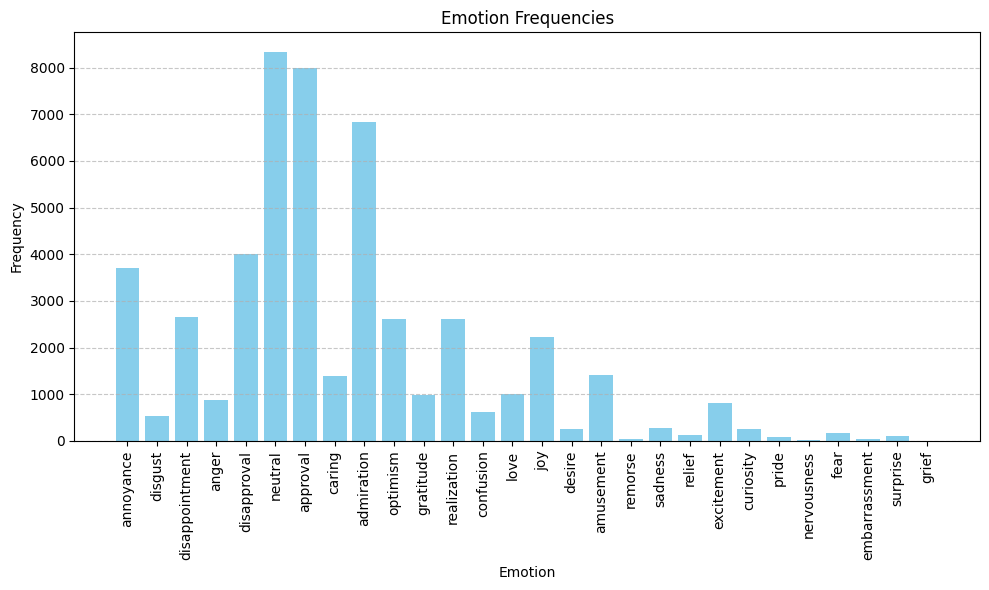

In [7]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency.keys())
frequencies = list(emotion_frequency.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

### **Find average scores for each emotion as they relate to difficulty and quality ratings and graph:**

ANOVA Table for annoyance based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    7.910941     4.0  89.263272  1.144168e-74
Residual       221.473403  9996.0        NaN           NaN

Regression Summary for annoyance based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              annoyance   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     89.26
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.14e-74
Time:                        23:46:29   Log-Likelihood:                 4861.8
No. Observations:               10001   AIC:                            -9714.
Df Residuals:                    9996   BIC:                            -9678.
Df Model:                           4                                         
Covariance

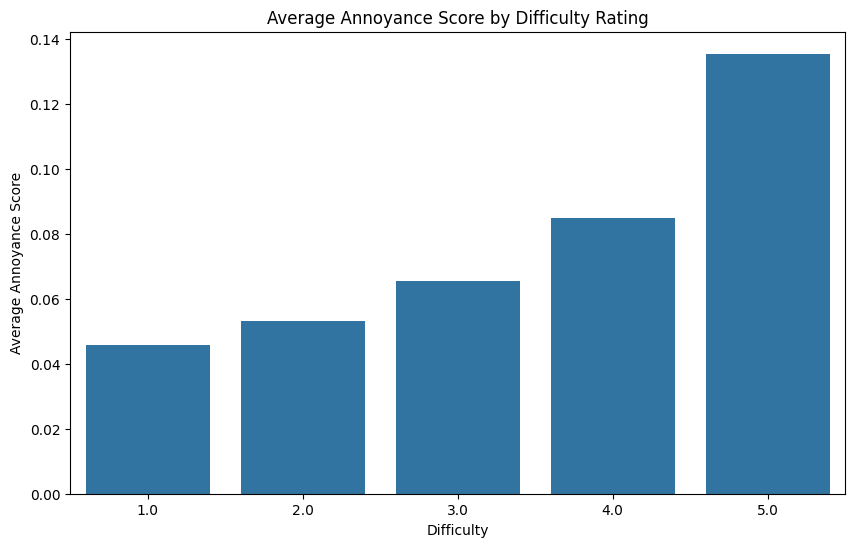

ANOVA Table for annoyance based on Quality:
                sum_sq      df           F  PR(>F)
C(Quality)   43.306320     8.0  290.682335     0.0
Residual    186.078023  9992.0         NaN     NaN

Regression Summary for annoyance based on Quality:
                            OLS Regression Results                            
Dep. Variable:              annoyance   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     290.7
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:46:30   Log-Likelihood:                 5732.6
No. Observations:               10001   AIC:                        -1.145e+04
Df Residuals:                    9992   BIC:                        -1.138e+04
Df Model:                           8                                         
Covariance Type:            nonrobust   

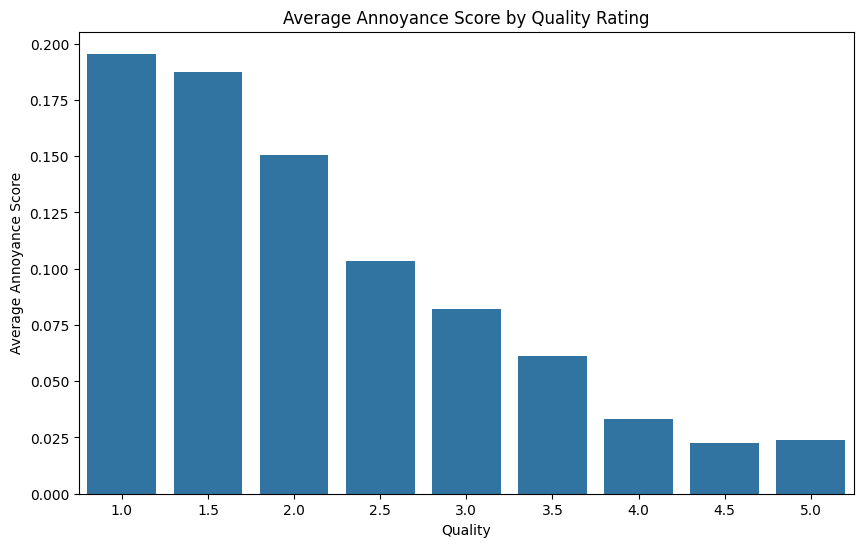

ANOVA Table for disgust based on Difficulty:
                  sum_sq      df          F        PR(>F)
C(Difficulty)   0.211198     4.0  25.536948  4.402967e-21
Residual       20.667455  9996.0        NaN           NaN

Regression Summary for disgust based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                disgust   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     25.54
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           4.40e-21
Time:                        23:46:30   Log-Likelihood:                 16722.
No. Observations:               10001   AIC:                        -3.343e+04
Df Residuals:                    9996   BIC:                        -3.340e+04
Df Model:                           4                                         
Covariance Type: 

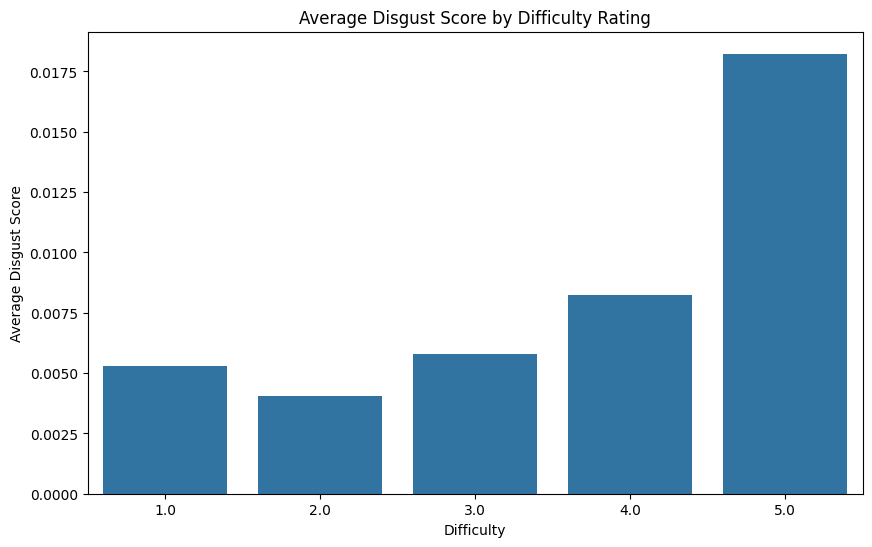

ANOVA Table for disgust based on Quality:
               sum_sq      df          F        PR(>F)
C(Quality)   0.908163     8.0  56.798595  5.595383e-91
Residual    19.970490  9992.0        NaN           NaN

Regression Summary for disgust based on Quality:
                            OLS Regression Results                            
Dep. Variable:                disgust   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     56.80
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           5.60e-91
Time:                        23:46:30   Log-Likelihood:                 16893.
No. Observations:               10001   AIC:                        -3.377e+04
Df Residuals:                    9992   BIC:                        -3.370e+04
Df Model:                           8                                         
Covariance Type:            nonr

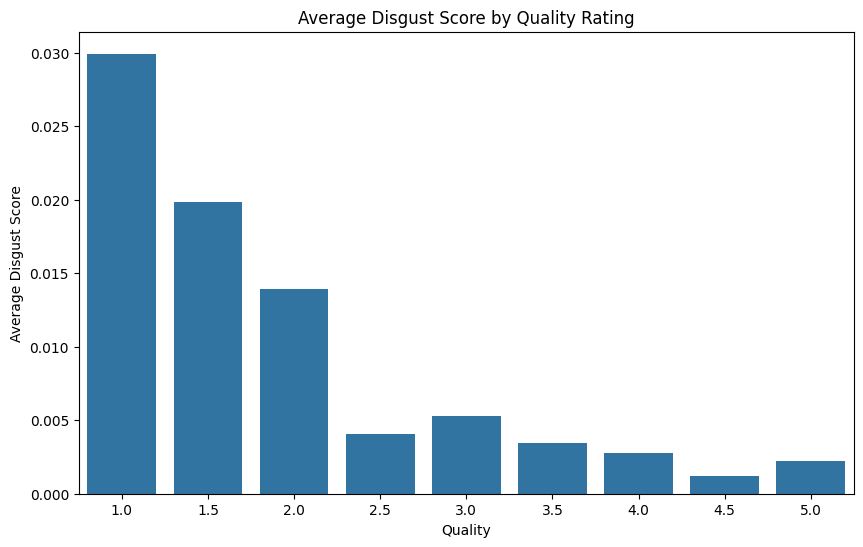

ANOVA Table for disappointment based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    0.952052     4.0  17.040469  6.184107e-14
Residual       139.619213  9996.0        NaN           NaN

Regression Summary for disappointment based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:         disappointment   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     17.04
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           6.18e-14
Time:                        23:46:30   Log-Likelihood:                 7168.9
No. Observations:               10001   AIC:                        -1.433e+04
Df Residuals:                    9996   BIC:                        -1.429e+04
Df Model:                           4                                         


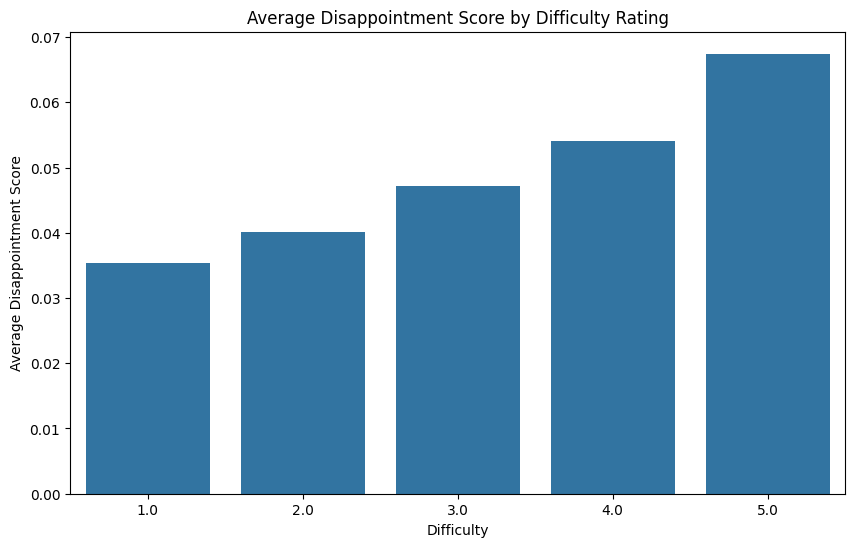

ANOVA Table for disappointment based on Quality:
                sum_sq      df           F         PR(>F)
C(Quality)   10.918088     8.0  105.178233  3.677809e-169
Residual    129.653177  9992.0         NaN            NaN

Regression Summary for disappointment based on Quality:
                            OLS Regression Results                            
Dep. Variable:         disappointment   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     105.2
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          3.68e-169
Time:                        23:46:31   Log-Likelihood:                 7539.3
No. Observations:               10001   AIC:                        -1.506e+04
Df Residuals:                    9992   BIC:                        -1.500e+04
Df Model:                           8                                         
Covarianc

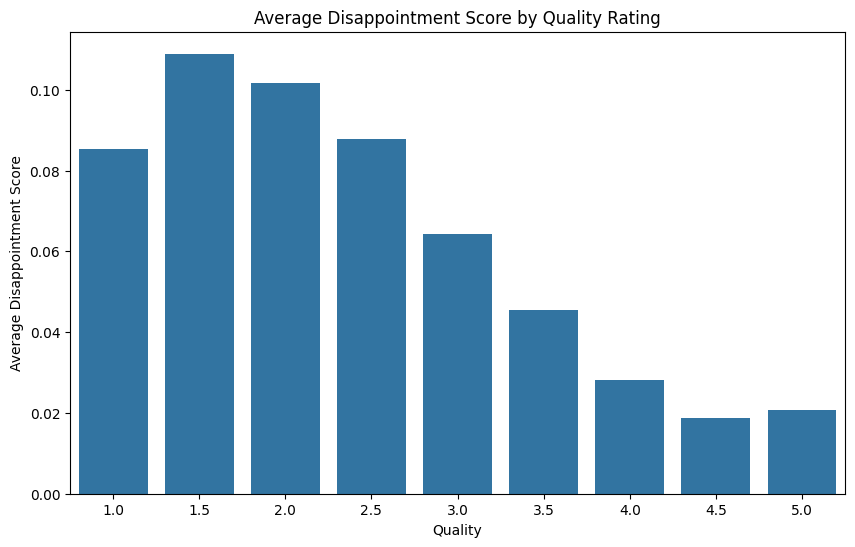

ANOVA Table for anger based on Difficulty:
                  sum_sq      df          F        PR(>F)
C(Difficulty)   0.514126     4.0  51.353829  7.142071e-43
Residual       25.018587  9996.0        NaN           NaN

Regression Summary for anger based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                  anger   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     51.35
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           7.14e-43
Time:                        23:46:31   Log-Likelihood:                 15766.
No. Observations:               10001   AIC:                        -3.152e+04
Df Residuals:                    9996   BIC:                        -3.149e+04
Df Model:                           4                                         
Covariance Type:     

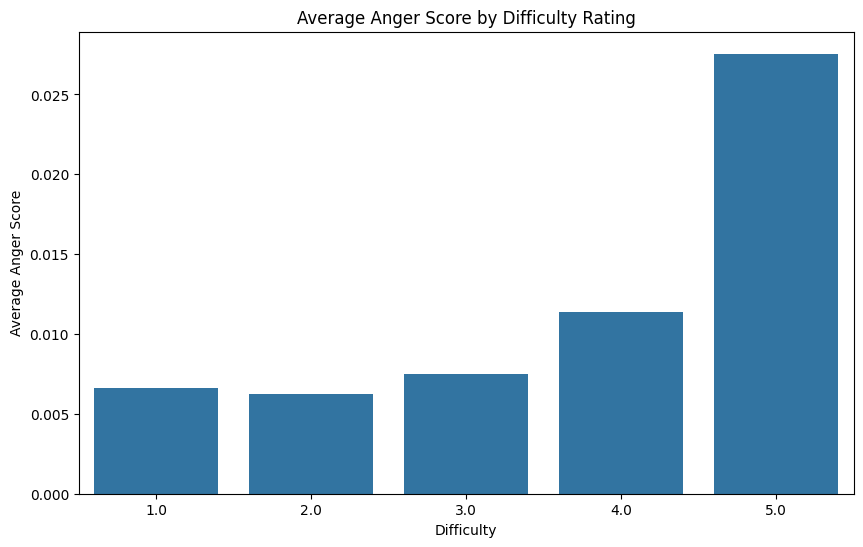

ANOVA Table for anger based on Quality:
               sum_sq      df          F         PR(>F)
C(Quality)   1.684674     8.0  88.231911  4.756642e-142
Residual    23.848039  9992.0        NaN            NaN

Regression Summary for anger based on Quality:
                            OLS Regression Results                            
Dep. Variable:                  anger   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     88.23
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          4.76e-142
Time:                        23:46:31   Log-Likelihood:                 16006.
No. Observations:               10001   AIC:                        -3.199e+04
Df Residuals:                    9992   BIC:                        -3.193e+04
Df Model:                           8                                         
Covariance Type:            nonro

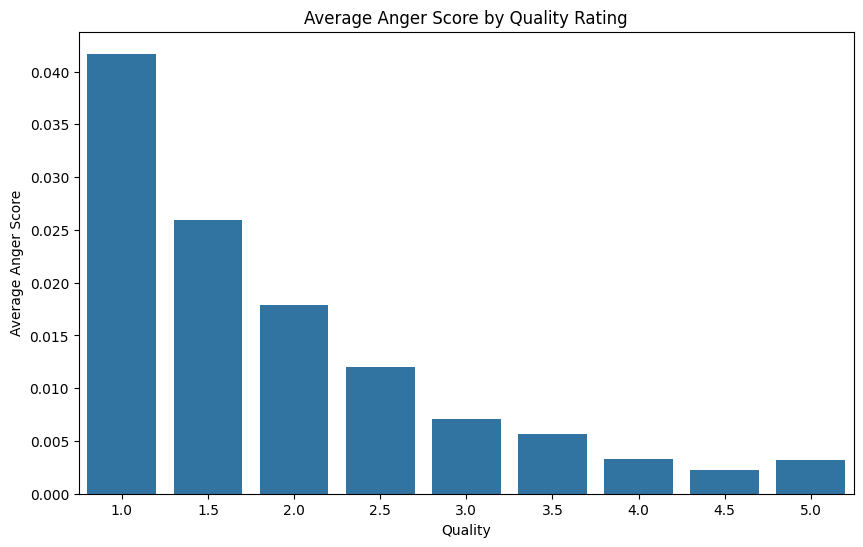

ANOVA Table for disapproval based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    4.608447     4.0  83.047588  1.767330e-69
Residual       138.673617  9996.0        NaN           NaN

Regression Summary for disapproval based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:            disapproval   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     83.05
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.77e-69
Time:                        23:46:32   Log-Likelihood:                 7202.9
No. Observations:               10001   AIC:                        -1.440e+04
Df Residuals:                    9996   BIC:                        -1.436e+04
Df Model:                           4                                         
Covari

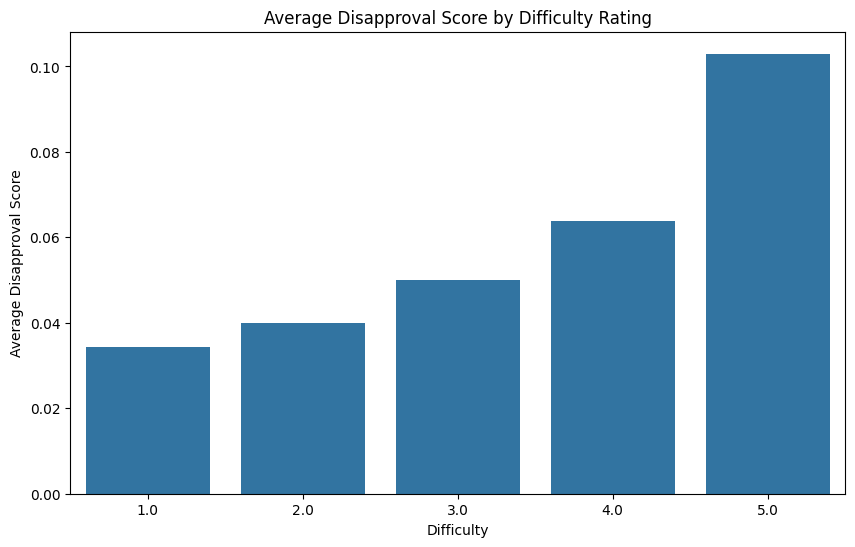

ANOVA Table for disapproval based on Quality:
                sum_sq      df           F         PR(>F)
C(Quality)   17.800199     8.0  177.176591  6.010260e-281
Residual    125.481865  9992.0         NaN            NaN

Regression Summary for disapproval based on Quality:
                            OLS Regression Results                            
Dep. Variable:            disapproval   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     177.2
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          6.01e-281
Time:                        23:46:32   Log-Likelihood:                 7702.8
No. Observations:               10001   AIC:                        -1.539e+04
Df Residuals:                    9992   BIC:                        -1.532e+04
Df Model:                           8                                         
Covariance Type

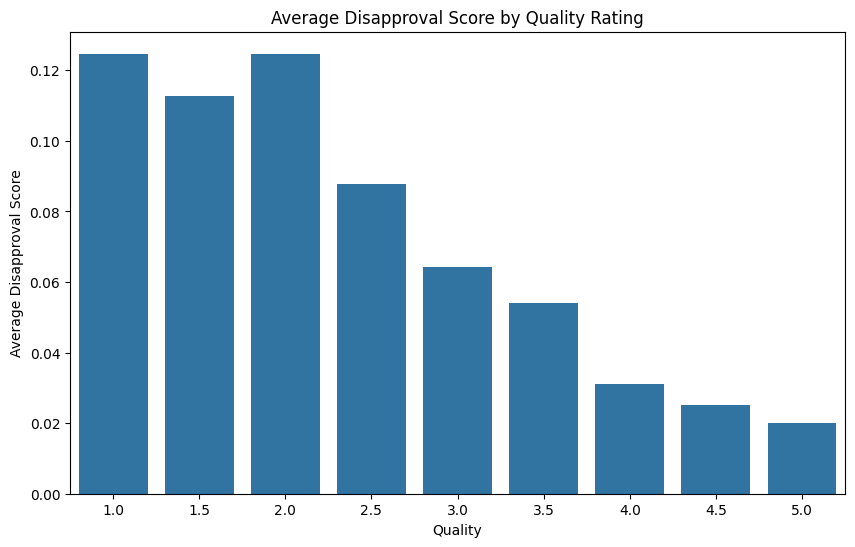

ANOVA Table for neutral based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    3.549234     4.0  13.411643  6.669766e-11
Residual       661.330993  9996.0        NaN           NaN

Regression Summary for neutral based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                neutral   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     13.41
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           6.67e-11
Time:                        23:46:33   Log-Likelihood:                -608.52
No. Observations:               10001   AIC:                             1227.
Df Residuals:                    9996   BIC:                             1263.
Df Model:                           4                                         
Covariance Typ

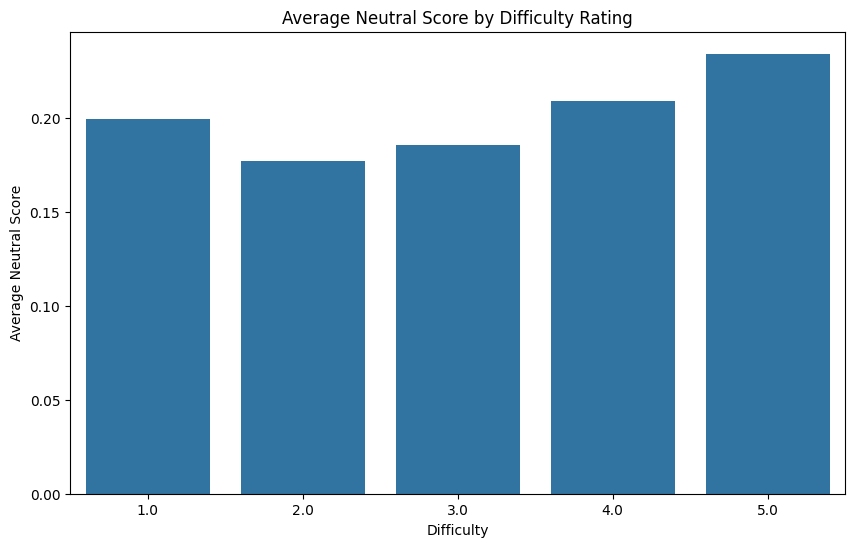

ANOVA Table for neutral based on Quality:
                sum_sq      df          F         PR(>F)
C(Quality)   31.744051     8.0  62.622105  1.635859e-100
Residual    633.136175  9992.0        NaN            NaN

Regression Summary for neutral based on Quality:
                            OLS Regression Results                            
Dep. Variable:                neutral   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     62.62
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          1.64e-100
Time:                        23:46:33   Log-Likelihood:                -390.65
No. Observations:               10001   AIC:                             799.3
Df Residuals:                    9992   BIC:                             864.2
Df Model:                           8                                         
Covariance Type:          

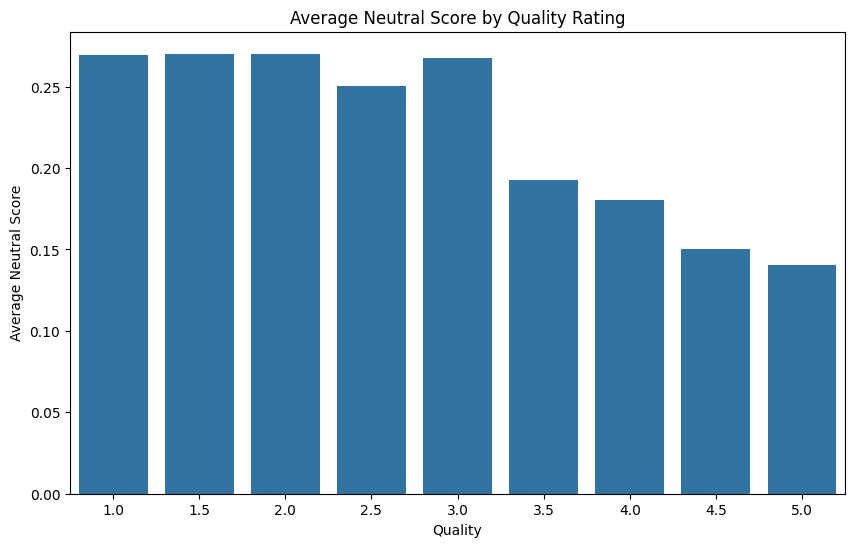

ANOVA Table for approval based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    3.242615     4.0  43.805965  1.660727e-36
Residual       184.981549  9996.0        NaN           NaN

Regression Summary for approval based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     43.81
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.66e-36
Time:                        23:46:33   Log-Likelihood:                 5762.1
No. Observations:               10001   AIC:                        -1.151e+04
Df Residuals:                    9996   BIC:                        -1.148e+04
Df Model:                           4                                         
Covariance T

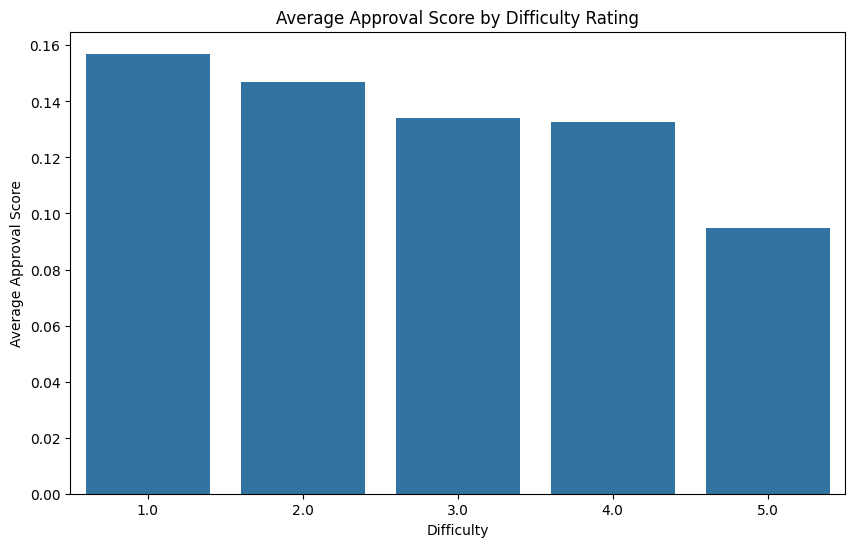

ANOVA Table for approval based on Quality:
                sum_sq      df          F         PR(>F)
C(Quality)   13.904885     8.0  99.628687  2.573538e-160
Residual    174.319279  9992.0        NaN            NaN

Regression Summary for approval based on Quality:
                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     99.63
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          2.57e-160
Time:                        23:46:33   Log-Likelihood:                 6059.0
No. Observations:               10001   AIC:                        -1.210e+04
Df Residuals:                    9992   BIC:                        -1.204e+04
Df Model:                           8                                         
Covariance Type:        

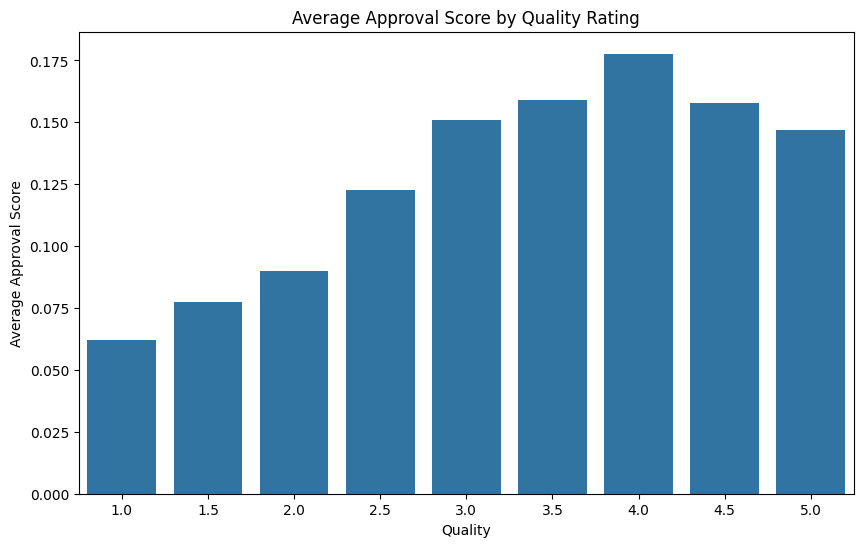

ANOVA Table for caring based on Difficulty:
                  sum_sq      df         F  PR(>F)
C(Difficulty)   0.092281     4.0  3.568016  0.0065
Residual       64.632482  9996.0       NaN     NaN

Regression Summary for caring based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                 caring   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.568
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00650
Time:                        23:46:34   Log-Likelihood:                 11020.
No. Observations:               10001   AIC:                        -2.203e+04
Df Residuals:                    9996   BIC:                        -2.199e+04
Df Model:                           4                                         
Covariance Type:            nonrobust   

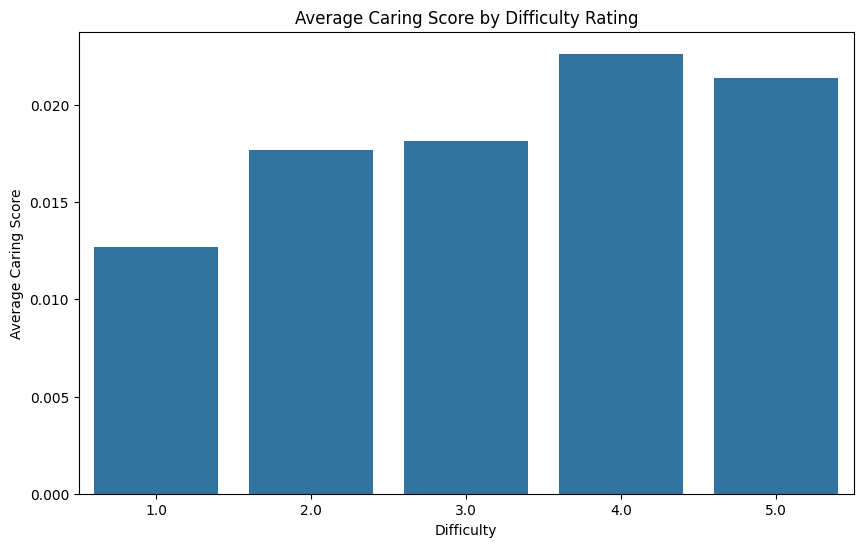

ANOVA Table for caring based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.069298     8.0  1.338682  0.218864
Residual    64.655465  9992.0       NaN       NaN

Regression Summary for caring based on Quality:
                            OLS Regression Results                            
Dep. Variable:                 caring   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.339
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.219
Time:                        23:46:34   Log-Likelihood:                 11019.
No. Observations:               10001   AIC:                        -2.202e+04
Df Residuals:                    9992   BIC:                        -2.195e+04
Df Model:                           8                                         
Covariance Type:            nonrobust            

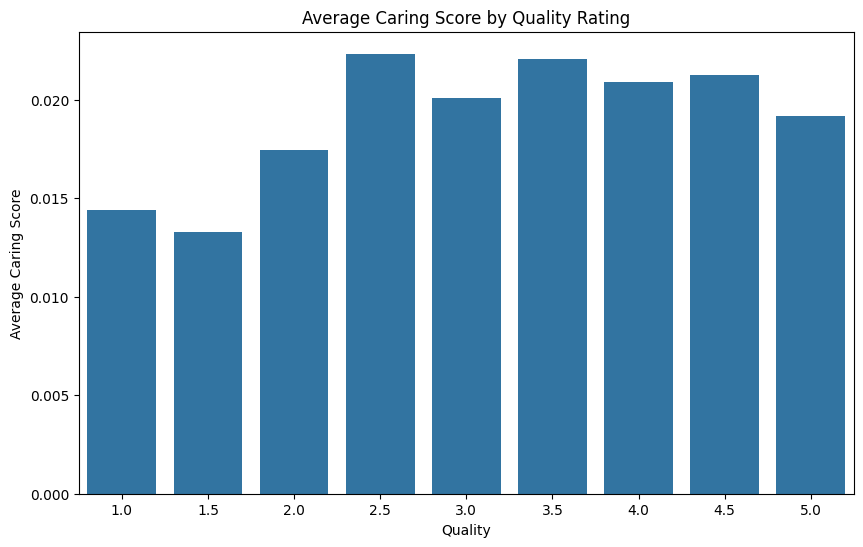

ANOVA Table for admiration based on Difficulty:
                    sum_sq      df          F        PR(>F)
C(Difficulty)    48.902577     4.0  87.675981  2.413077e-73
Residual       1393.854274  9996.0        NaN           NaN

Regression Summary for admiration based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:             admiration   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     87.68
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           2.41e-73
Time:                        23:46:34   Log-Likelihood:                -4336.8
No. Observations:               10001   AIC:                             8684.
Df Residuals:                    9996   BIC:                             8720.
Df Model:                           4                                         
Covar

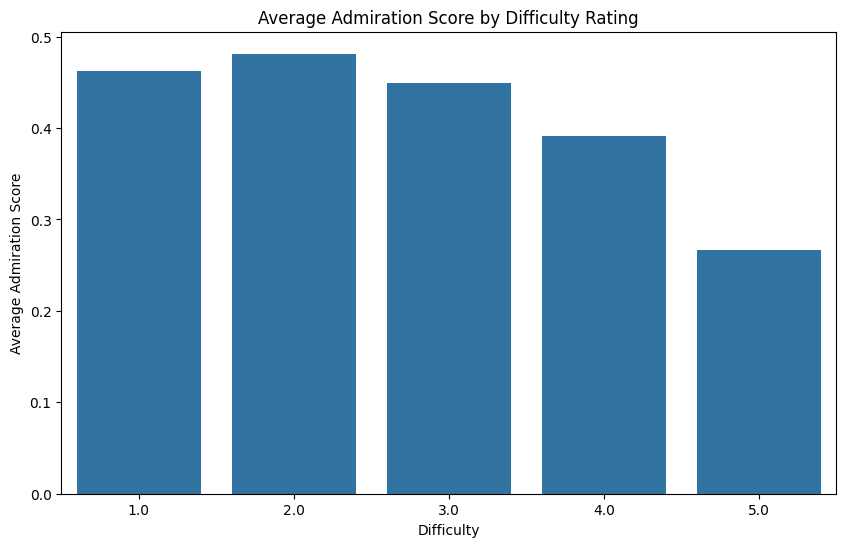

ANOVA Table for admiration based on Quality:
                 sum_sq      df           F  PR(>F)
C(Quality)   356.017158     8.0  409.173818     0.0
Residual    1086.739694  9992.0         NaN     NaN

Regression Summary for admiration based on Quality:
                            OLS Regression Results                            
Dep. Variable:             admiration   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     409.2
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:46:35   Log-Likelihood:                -3092.2
No. Observations:               10001   AIC:                             6202.
Df Residuals:                    9992   BIC:                             6267.
Df Model:                           8                                         
Covariance Type:            nonrobu

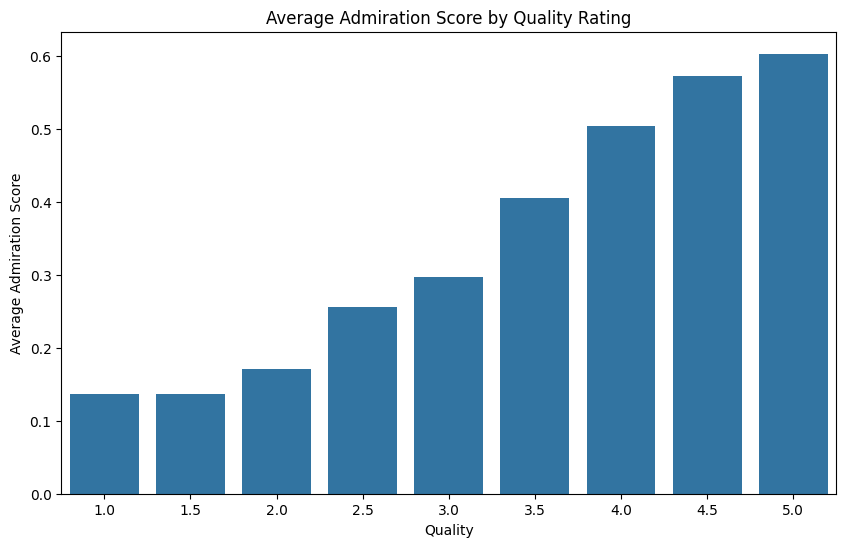

ANOVA Table for optimism based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.065668     4.0  4.898934  0.000605
Residual       33.498099  9996.0       NaN       NaN

Regression Summary for optimism based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:               optimism   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.899
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           0.000605
Time:                        23:46:35   Log-Likelihood:                 14307.
No. Observations:               10001   AIC:                        -2.860e+04
Df Residuals:                    9996   BIC:                        -2.857e+04
Df Model:                           4                                         
Covariance Type:            no

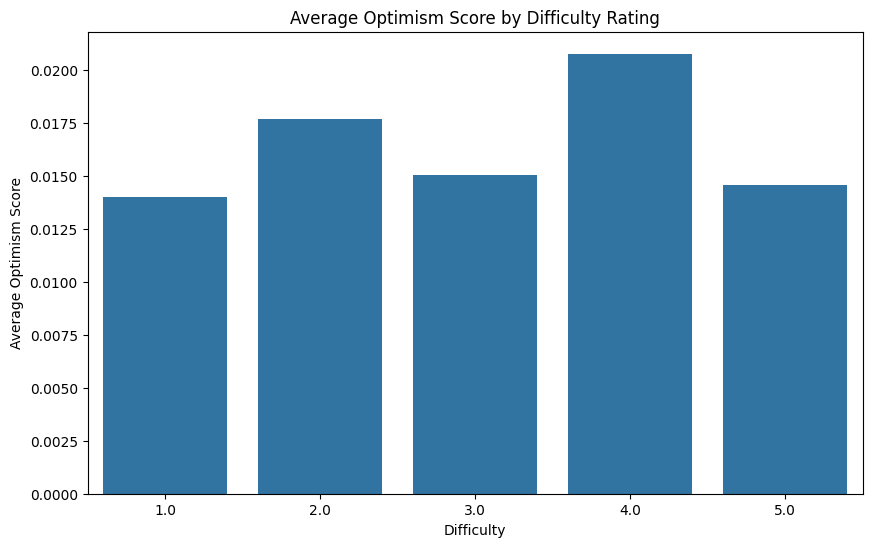

ANOVA Table for optimism based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.142998     8.0  5.344099  0.000001
Residual    33.420770  9992.0       NaN       NaN

Regression Summary for optimism based on Quality:
                            OLS Regression Results                            
Dep. Variable:               optimism   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.344
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.01e-06
Time:                        23:46:35   Log-Likelihood:                 14318.
No. Observations:               10001   AIC:                        -2.862e+04
Df Residuals:                    9992   BIC:                        -2.855e+04
Df Model:                           8                                         
Covariance Type:            nonrobust        

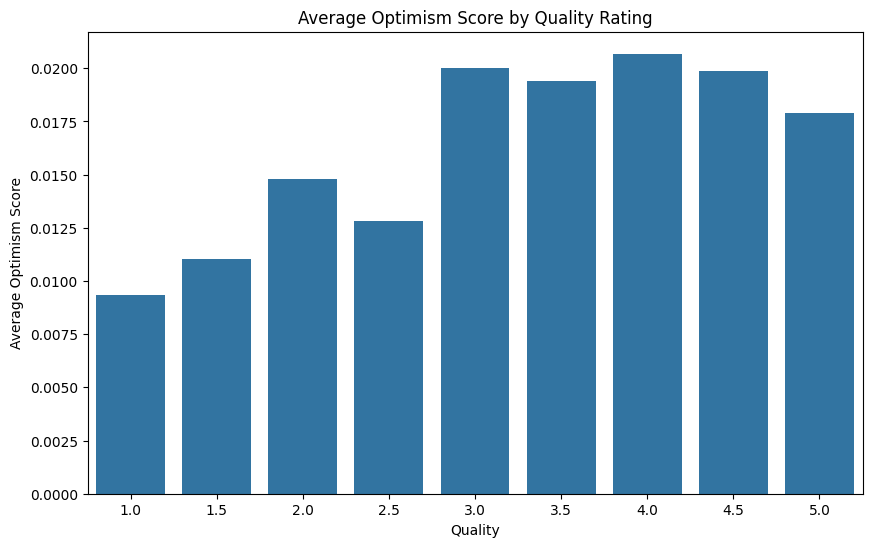

ANOVA Table for gratitude based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.022133     4.0  2.043403  0.085508
Residual       27.067410  9996.0       NaN       NaN

Regression Summary for gratitude based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              gratitude   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.043
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0855
Time:                        23:46:35   Log-Likelihood:                 15373.
No. Observations:               10001   AIC:                        -3.074e+04
Df Residuals:                    9996   BIC:                        -3.070e+04
Df Model:                           4                                         
Covariance Type:            

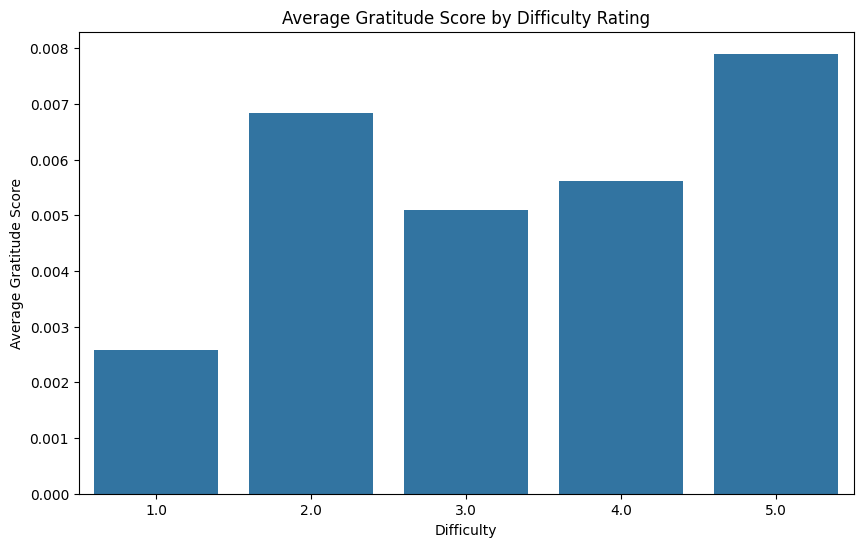

ANOVA Table for gratitude based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.063576     8.0  2.938163  0.002795
Residual    27.025967  9992.0       NaN       NaN

Regression Summary for gratitude based on Quality:
                            OLS Regression Results                            
Dep. Variable:              gratitude   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.938
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00279
Time:                        23:46:36   Log-Likelihood:                 15380.
No. Observations:               10001   AIC:                        -3.074e+04
Df Residuals:                    9992   BIC:                        -3.068e+04
Df Model:                           8                                         
Covariance Type:            nonrobust      

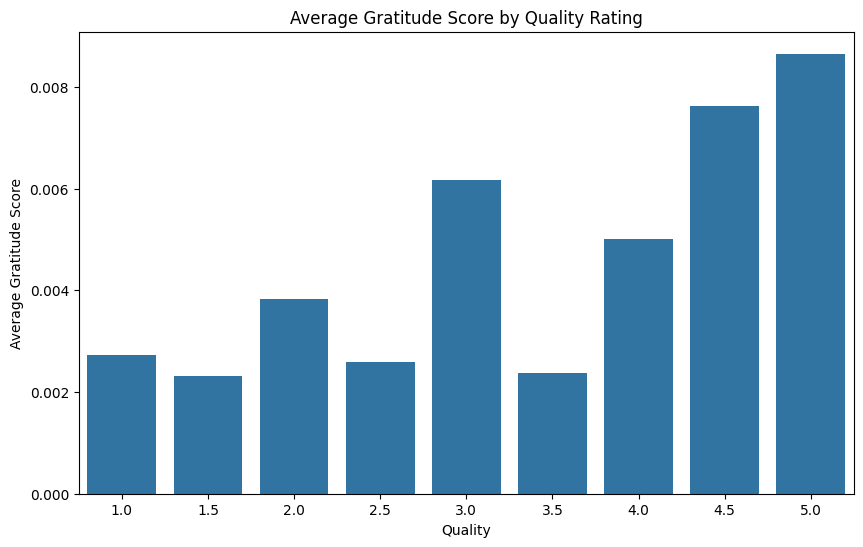

ANOVA Table for realization based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.006102     4.0  1.113606  0.348052
Residual       13.692946  9996.0       NaN       NaN

Regression Summary for realization based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:            realization   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.114
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.348
Time:                        23:46:36   Log-Likelihood:                 18780.
No. Observations:               10001   AIC:                        -3.755e+04
Df Residuals:                    9996   BIC:                        -3.751e+04
Df Model:                           4                                         
Covariance Type:        

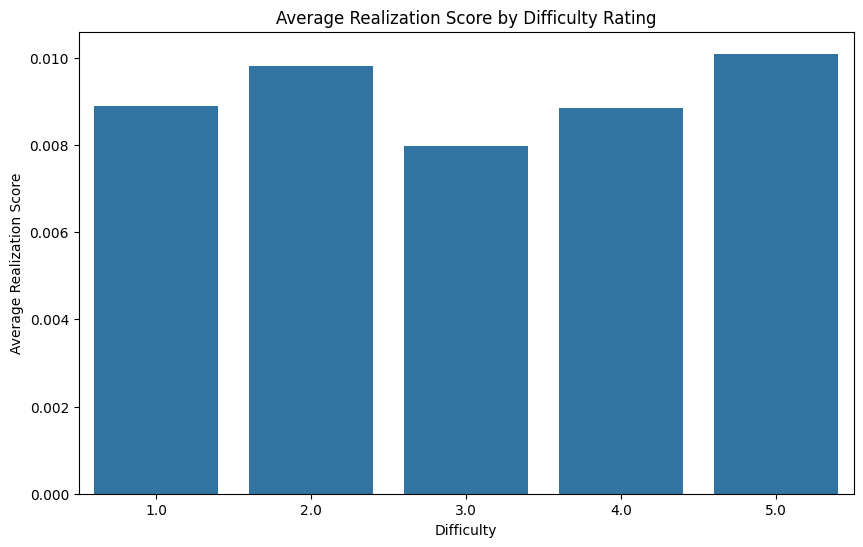

ANOVA Table for realization based on Quality:
               sum_sq      df         F        PR(>F)
C(Quality)   0.068613     8.0  6.287197  3.763040e-08
Residual    13.630435  9992.0       NaN           NaN

Regression Summary for realization based on Quality:
                            OLS Regression Results                            
Dep. Variable:            realization   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.287
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           3.76e-08
Time:                        23:46:36   Log-Likelihood:                 18803.
No. Observations:               10001   AIC:                        -3.759e+04
Df Residuals:                    9992   BIC:                        -3.752e+04
Df Model:                           8                                         
Covariance Type:           

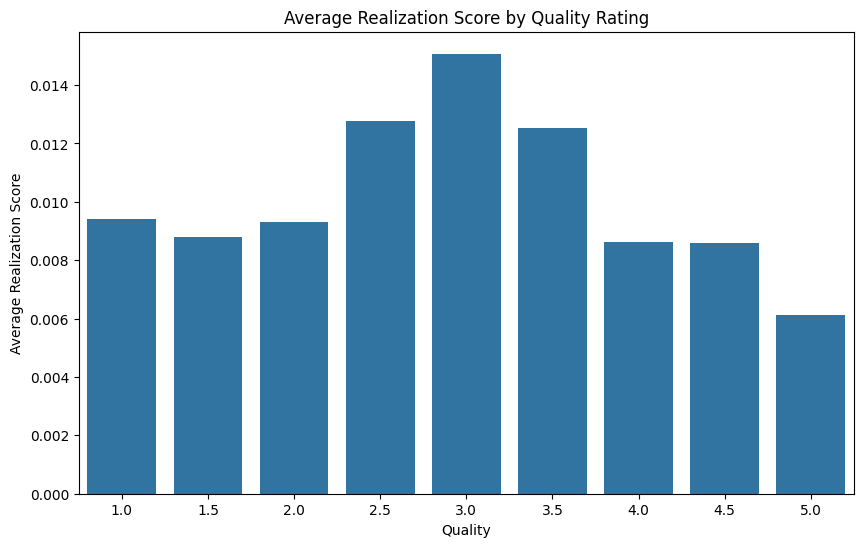

ANOVA Table for confusion based on Difficulty:
                   sum_sq      df         F    PR(>F)
C(Difficulty)    0.250025     4.0  5.148701  0.000384
Residual       121.353199  9996.0       NaN       NaN

Regression Summary for confusion based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              confusion   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.149
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           0.000384
Time:                        23:46:37   Log-Likelihood:                 7870.1
No. Observations:               10001   AIC:                        -1.573e+04
Df Residuals:                    9996   BIC:                        -1.569e+04
Df Model:                           4                                         
Covariance Type:         

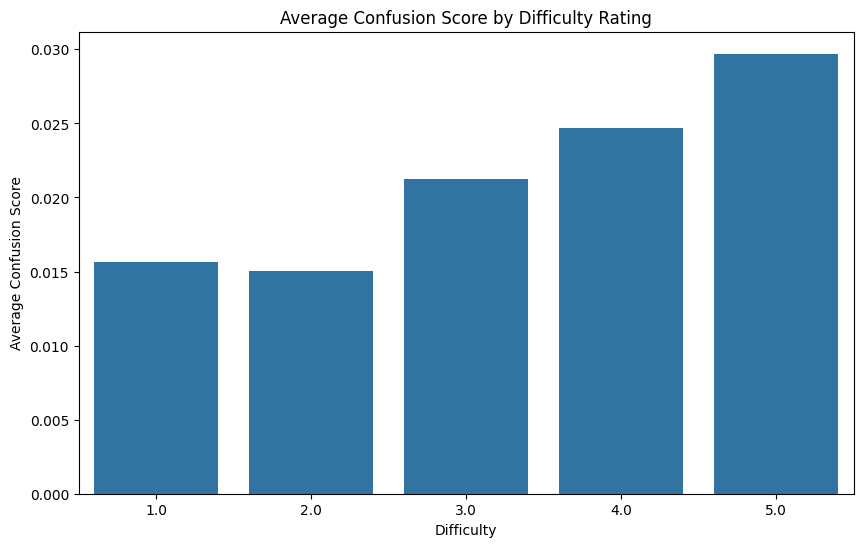

ANOVA Table for confusion based on Quality:
                sum_sq      df          F        PR(>F)
C(Quality)    2.090086     8.0  21.842934  2.641211e-33
Residual    119.513137  9992.0        NaN           NaN

Regression Summary for confusion based on Quality:
                            OLS Regression Results                            
Dep. Variable:              confusion   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     21.84
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           2.64e-33
Time:                        23:46:37   Log-Likelihood:                 7946.5
No. Observations:               10001   AIC:                        -1.587e+04
Df Residuals:                    9992   BIC:                        -1.581e+04
Df Model:                           8                                         
Covariance Type:         

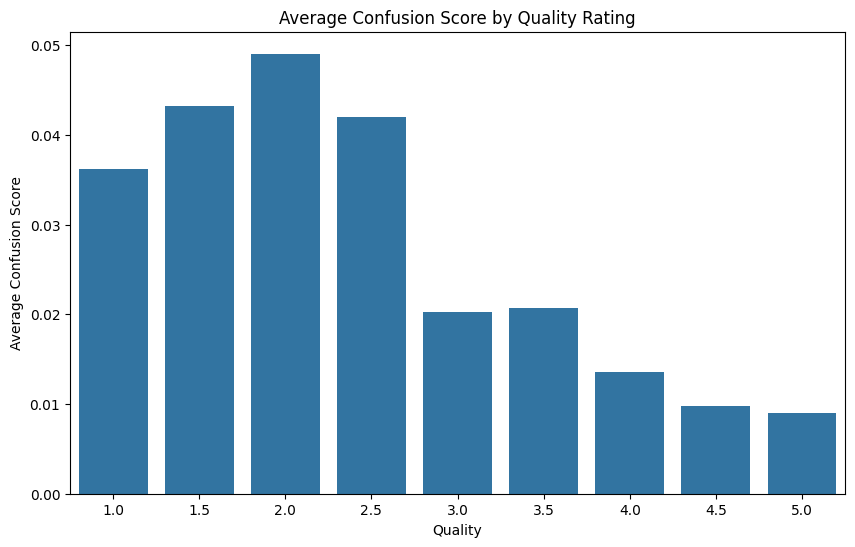

ANOVA Table for love based on Difficulty:
                   sum_sq      df         F        PR(>F)
C(Difficulty)    0.518014     4.0  8.898103  3.610287e-07
Residual       145.482429  9996.0       NaN           NaN

Regression Summary for love based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                   love   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.898
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           3.61e-07
Time:                        23:46:37   Log-Likelihood:                 6963.2
No. Observations:               10001   AIC:                        -1.392e+04
Df Residuals:                    9996   BIC:                        -1.388e+04
Df Model:                           4                                         
Covariance Type:       

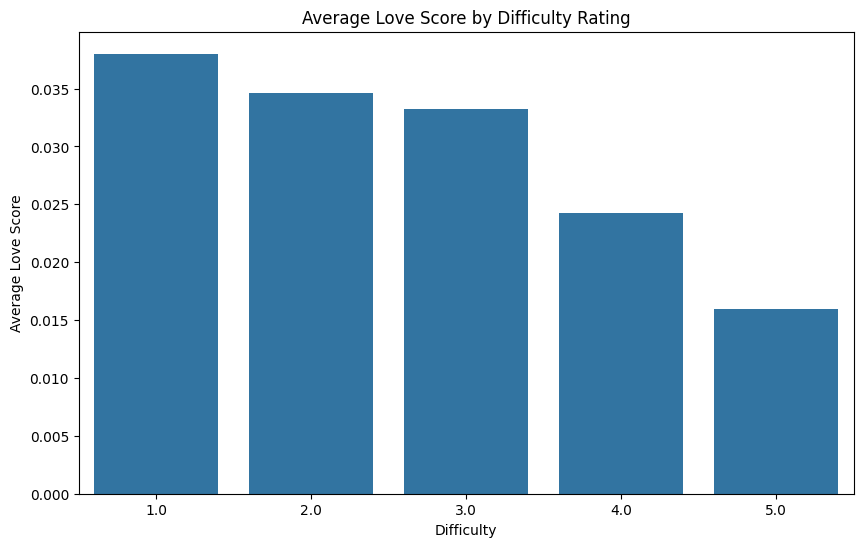

ANOVA Table for love based on Quality:
                sum_sq      df          F        PR(>F)
C(Quality)    1.932935     8.0  16.757667  6.108179e-25
Residual    144.067509  9992.0        NaN           NaN

Regression Summary for love based on Quality:
                            OLS Regression Results                            
Dep. Variable:                   love   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     16.76
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           6.11e-25
Time:                        23:46:38   Log-Likelihood:                 7012.1
No. Observations:               10001   AIC:                        -1.401e+04
Df Residuals:                    9992   BIC:                        -1.394e+04
Df Model:                           8                                         
Covariance Type:            nonrobu

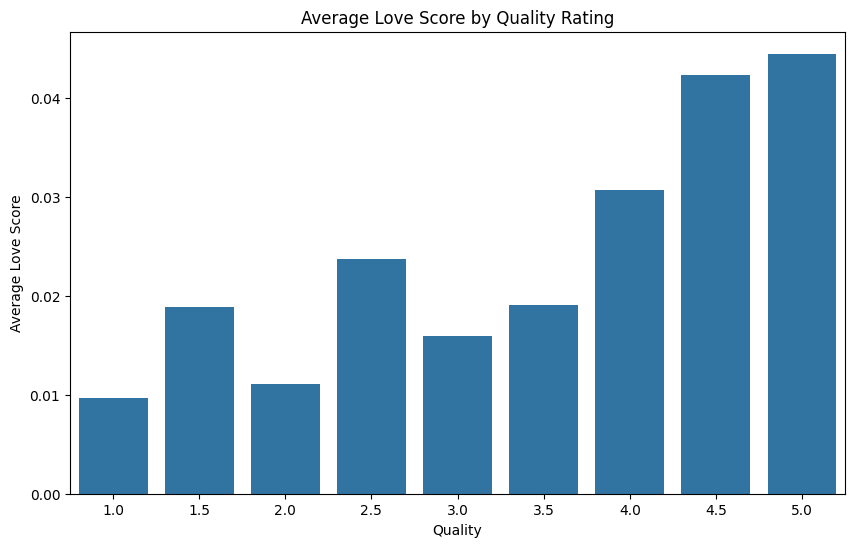

ANOVA Table for joy based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    3.269170     4.0  30.476325  2.989483e-25
Residual       268.065622  9996.0        NaN           NaN

Regression Summary for joy based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                    joy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     30.48
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           2.99e-25
Time:                        23:46:38   Log-Likelihood:                 3907.0
No. Observations:               10001   AIC:                            -7804.
Df Residuals:                    9996   BIC:                            -7768.
Df Model:                           4                                         
Covariance Type:      

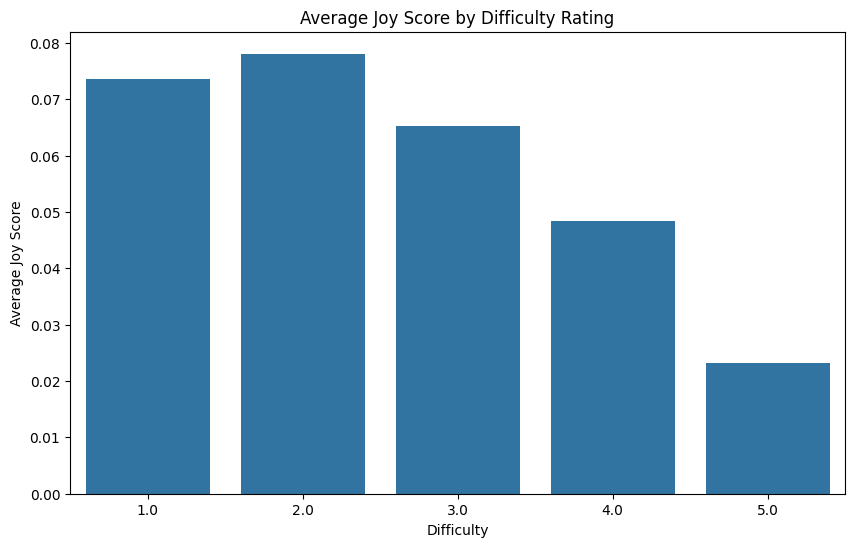

ANOVA Table for joy based on Quality:
                sum_sq      df          F        PR(>F)
C(Quality)    7.576285     8.0  35.876684  1.657088e-56
Residual    263.758506  9992.0        NaN           NaN

Regression Summary for joy based on Quality:
                            OLS Regression Results                            
Dep. Variable:                    joy   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     35.88
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.66e-56
Time:                        23:46:38   Log-Likelihood:                 3988.0
No. Observations:               10001   AIC:                            -7958.
Df Residuals:                    9992   BIC:                            -7893.
Df Model:                           8                                         
Covariance Type:            nonrobust

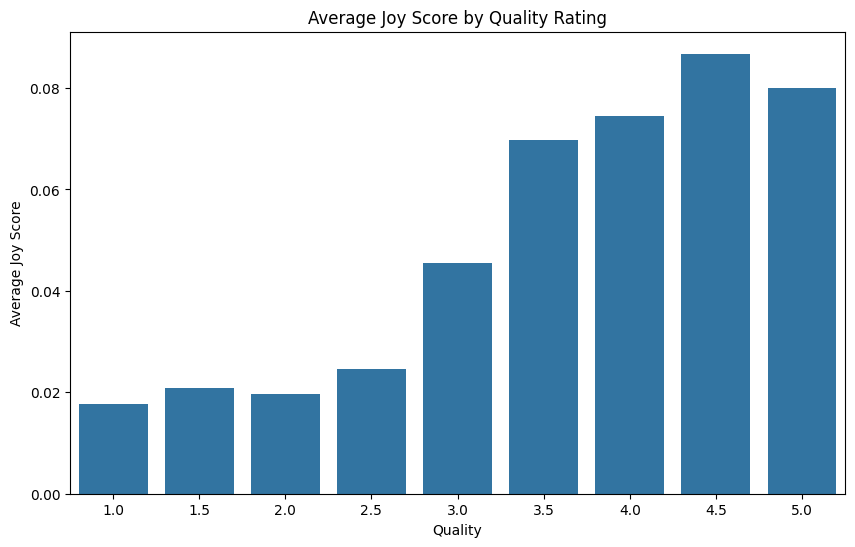

ANOVA Table for desire based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.019291     4.0  1.667203  0.154552
Residual       28.915418  9996.0       NaN       NaN

Regression Summary for desire based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                 desire   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.667
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.155
Time:                        23:46:39   Log-Likelihood:                 15042.
No. Observations:               10001   AIC:                        -3.007e+04
Df Residuals:                    9996   BIC:                        -3.004e+04
Df Model:                           4                                         
Covariance Type:            nonrob

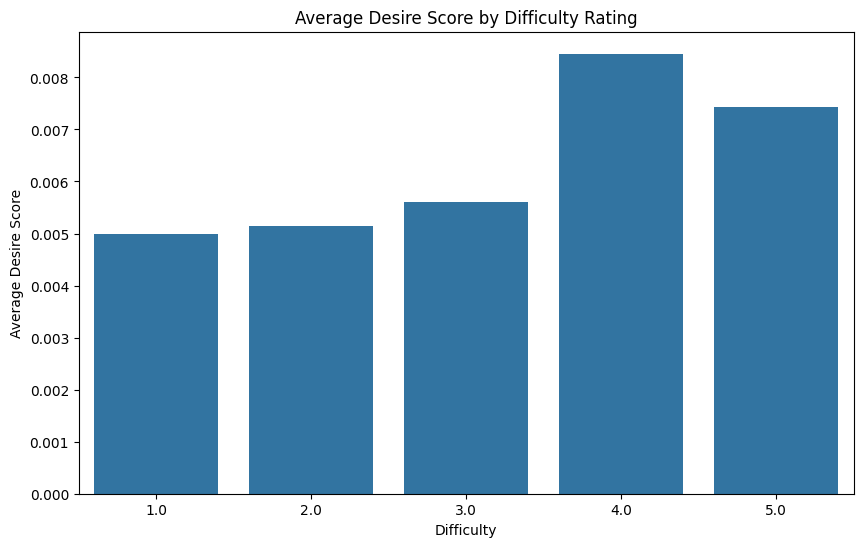

ANOVA Table for desire based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.051663     8.0  2.234088  0.022284
Residual    28.883046  9992.0       NaN       NaN

Regression Summary for desire based on Quality:
                            OLS Regression Results                            
Dep. Variable:                 desire   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.234
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0223
Time:                        23:46:39   Log-Likelihood:                 15048.
No. Observations:               10001   AIC:                        -3.008e+04
Df Residuals:                    9992   BIC:                        -3.001e+04
Df Model:                           8                                         
Covariance Type:            nonrobust            

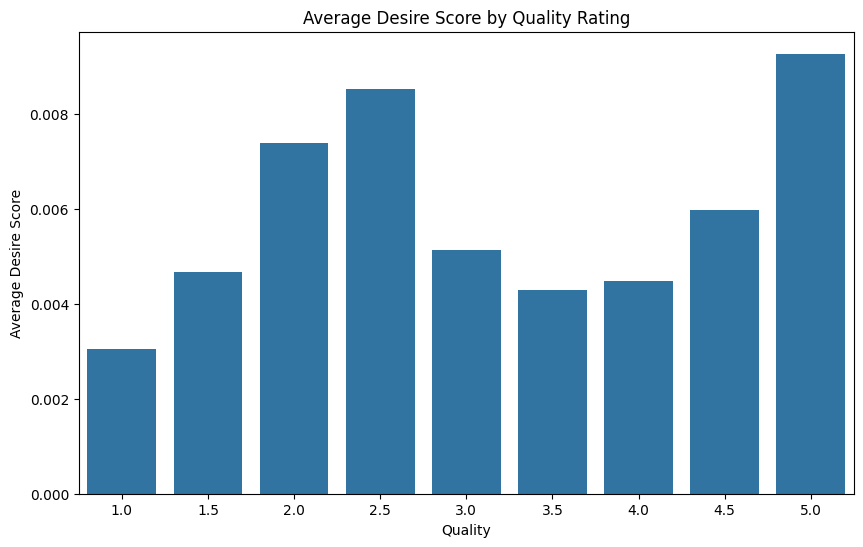

ANOVA Table for amusement based on Difficulty:
                   sum_sq      df         F        PR(>F)
C(Difficulty)    0.816332     4.0  12.18944  6.927353e-10
Residual       167.359157  9996.0       NaN           NaN

Regression Summary for amusement based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              amusement   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     12.19
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           6.93e-10
Time:                        23:46:39   Log-Likelihood:                 6262.7
No. Observations:               10001   AIC:                        -1.252e+04
Df Residuals:                    9996   BIC:                        -1.248e+04
Df Model:                           4                                         
Covariance Ty

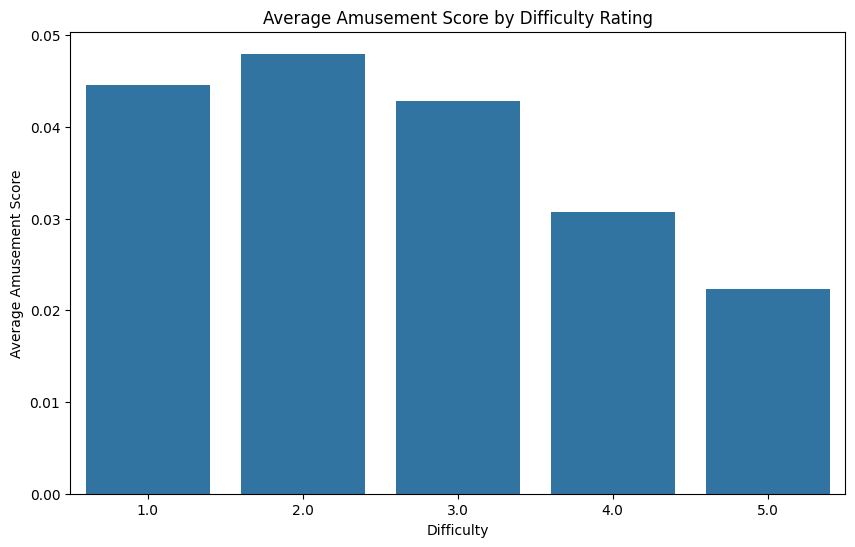

ANOVA Table for amusement based on Quality:
                sum_sq      df         F        PR(>F)
C(Quality)    1.594607     8.0  11.95614  4.029568e-17
Residual    166.580882  9992.0       NaN           NaN

Regression Summary for amusement based on Quality:
                            OLS Regression Results                            
Dep. Variable:              amusement   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.96
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           4.03e-17
Time:                        23:46:40   Log-Likelihood:                 6286.0
No. Observations:               10001   AIC:                        -1.255e+04
Df Residuals:                    9992   BIC:                        -1.249e+04
Df Model:                           8                                         
Covariance Type:            

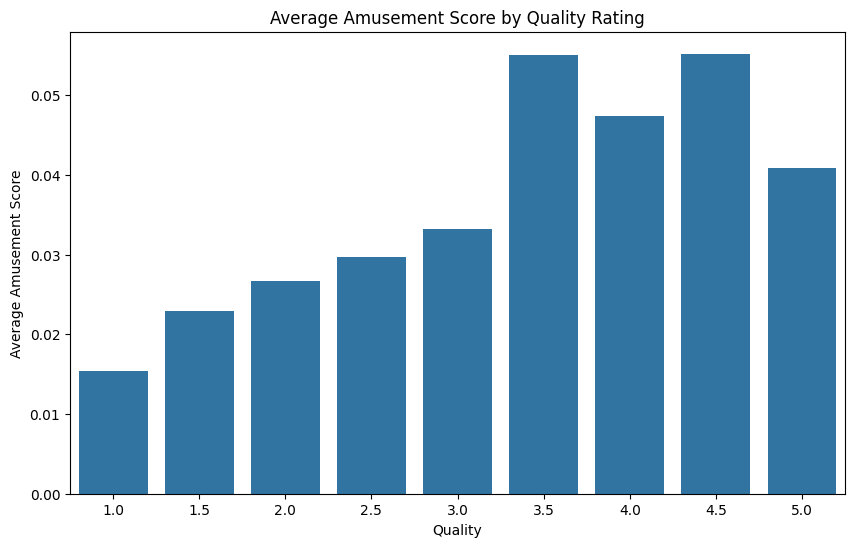

ANOVA Table for remorse based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.008145     4.0  1.980363  0.094587
Residual       10.278407  9996.0       NaN       NaN

Regression Summary for remorse based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                remorse   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.980
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0946
Time:                        23:46:40   Log-Likelihood:                 20215.
No. Observations:               10001   AIC:                        -4.042e+04
Df Residuals:                    9996   BIC:                        -4.038e+04
Df Model:                           4                                         
Covariance Type:            nonr

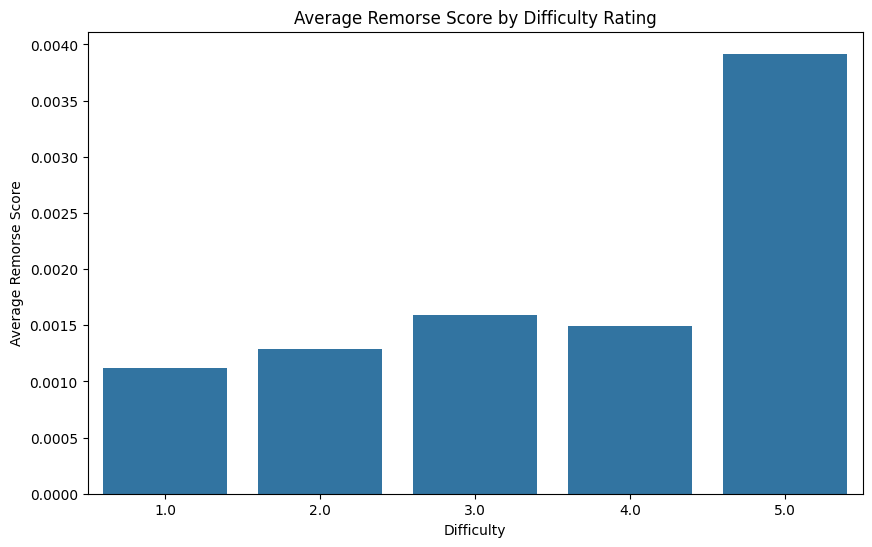

ANOVA Table for remorse based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.022268     8.0  2.709679  0.005585
Residual    10.264284  9992.0       NaN       NaN

Regression Summary for remorse based on Quality:
                            OLS Regression Results                            
Dep. Variable:                remorse   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.710
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00559
Time:                        23:46:40   Log-Likelihood:                 20221.
No. Observations:               10001   AIC:                        -4.042e+04
Df Residuals:                    9992   BIC:                        -4.036e+04
Df Model:                           8                                         
Covariance Type:            nonrobust          

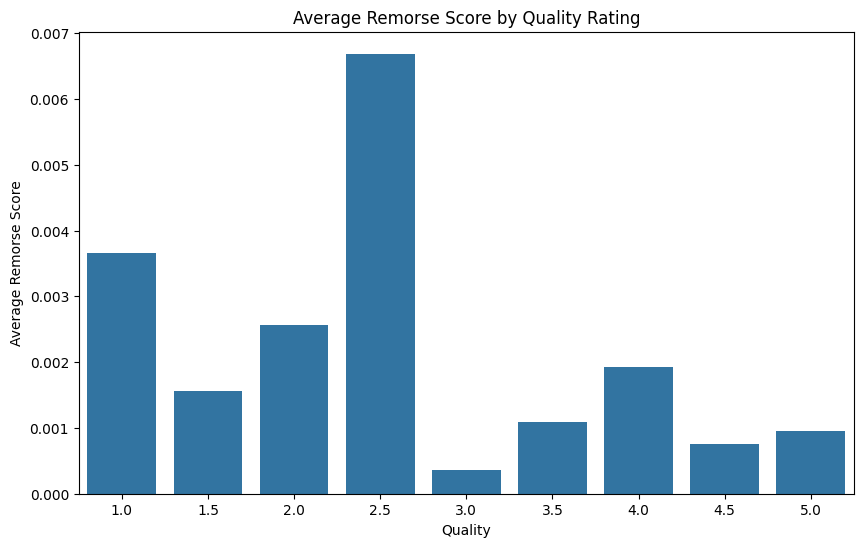

ANOVA Table for sadness based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.007717     4.0  1.151827  0.330081
Residual       16.742390  9996.0       NaN       NaN

Regression Summary for sadness based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                sadness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.152
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.330
Time:                        23:46:40   Log-Likelihood:                 17775.
No. Observations:               10001   AIC:                        -3.554e+04
Df Residuals:                    9996   BIC:                        -3.550e+04
Df Model:                           4                                         
Covariance Type:            nonr

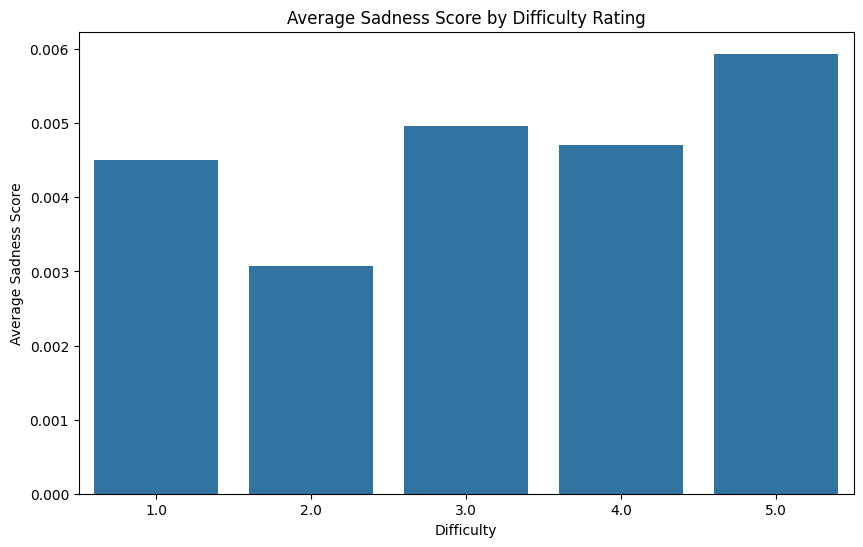

ANOVA Table for sadness based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.038303     8.0  2.862664  0.003519
Residual    16.711804  9992.0       NaN       NaN

Regression Summary for sadness based on Quality:
                            OLS Regression Results                            
Dep. Variable:                sadness   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.863
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00352
Time:                        23:46:41   Log-Likelihood:                 17784.
No. Observations:               10001   AIC:                        -3.555e+04
Df Residuals:                    9992   BIC:                        -3.549e+04
Df Model:                           8                                         
Covariance Type:            nonrobust          

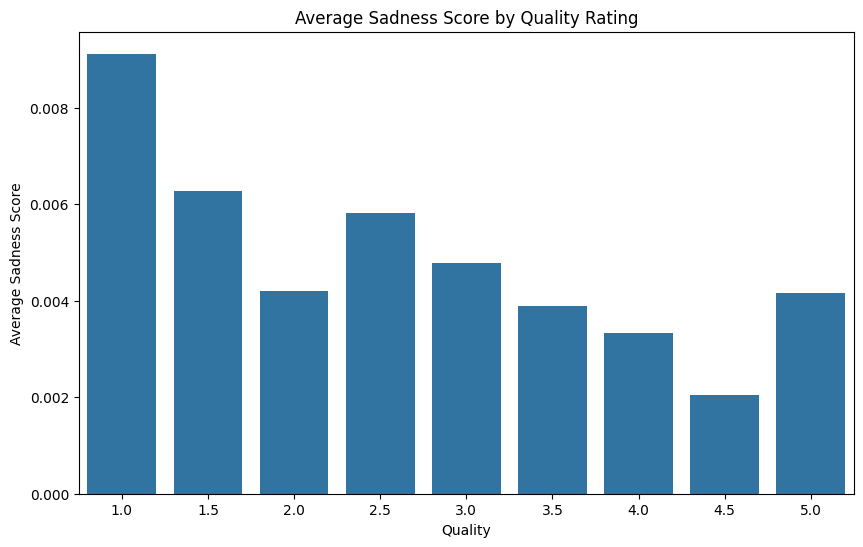

ANOVA Table for relief based on Difficulty:
                 sum_sq      df        F    PR(>F)
C(Difficulty)  0.000361     4.0  2.45707  0.043491
Residual       0.367345  9996.0      NaN       NaN

Regression Summary for relief based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                 relief   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.457
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0435
Time:                        23:46:41   Log-Likelihood:                 36874.
No. Observations:               10001   AIC:                        -7.374e+04
Df Residuals:                    9996   BIC:                        -7.370e+04
Df Model:                           4                                         
Covariance Type:            nonrobust   

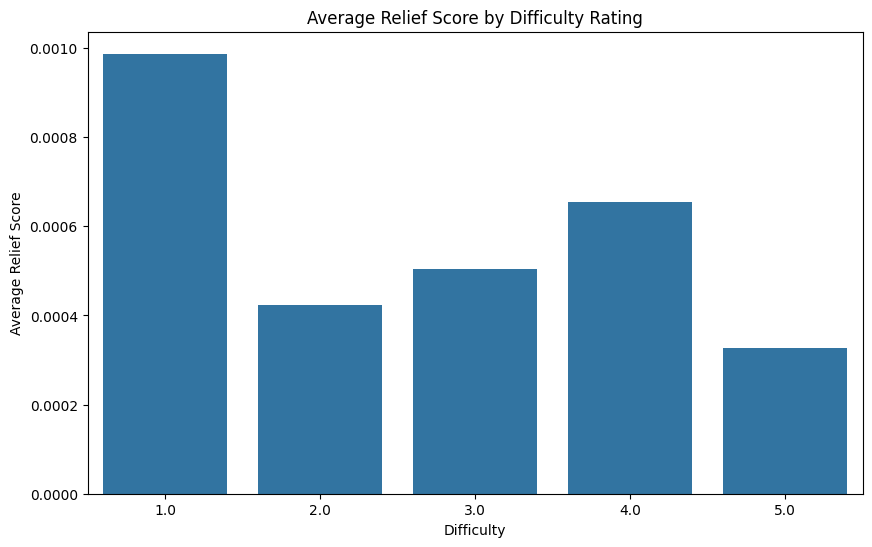

ANOVA Table for relief based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000738     8.0  2.510212  0.010083
Residual    0.366969  9992.0       NaN       NaN

Regression Summary for relief based on Quality:
                            OLS Regression Results                            
Dep. Variable:                 relief   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.510
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0101
Time:                        23:46:41   Log-Likelihood:                 36879.
No. Observations:               10001   AIC:                        -7.374e+04
Df Residuals:                    9992   BIC:                        -7.367e+04
Df Model:                           8                                         
Covariance Type:            nonrobust               

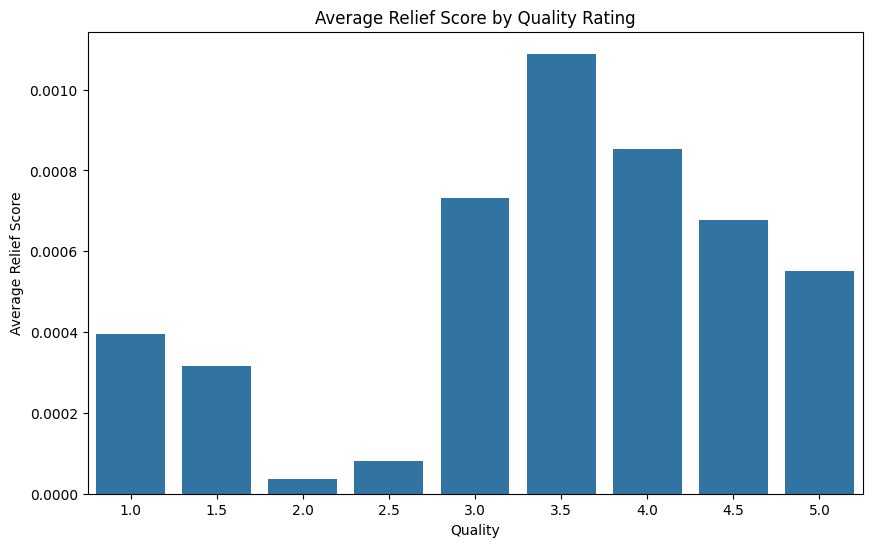

ANOVA Table for excitement based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.040124     4.0  7.052627  0.000012
Residual       14.217305  9996.0       NaN       NaN

Regression Summary for excitement based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:             excitement   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.053
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.15e-05
Time:                        23:46:42   Log-Likelihood:                 18592.
No. Observations:               10001   AIC:                        -3.717e+04
Df Residuals:                    9996   BIC:                        -3.714e+04
Df Model:                           4                                         
Covariance Type:          

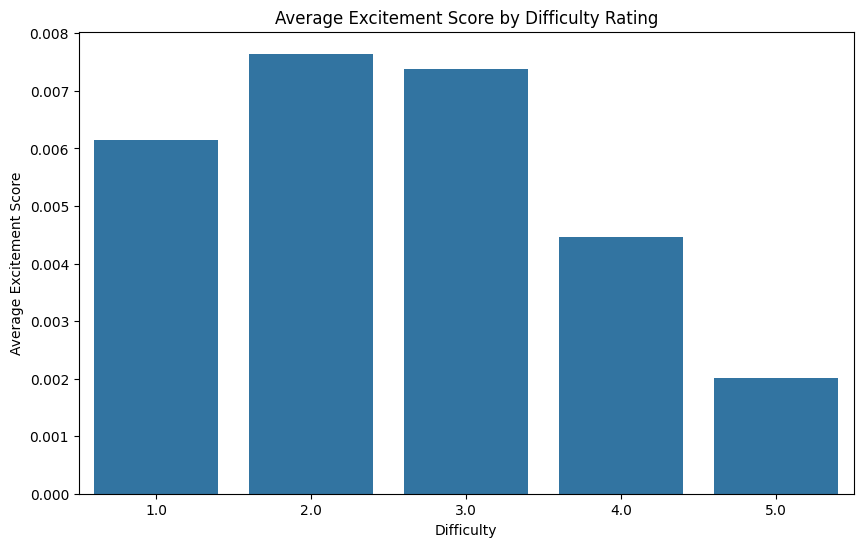

ANOVA Table for excitement based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.052552     8.0  4.620794  0.000012
Residual    14.204876  9992.0       NaN       NaN

Regression Summary for excitement based on Quality:
                            OLS Regression Results                            
Dep. Variable:             excitement   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.621
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.20e-05
Time:                        23:46:42   Log-Likelihood:                 18597.
No. Observations:               10001   AIC:                        -3.718e+04
Df Residuals:                    9992   BIC:                        -3.711e+04
Df Model:                           8                                         
Covariance Type:            nonrobust    

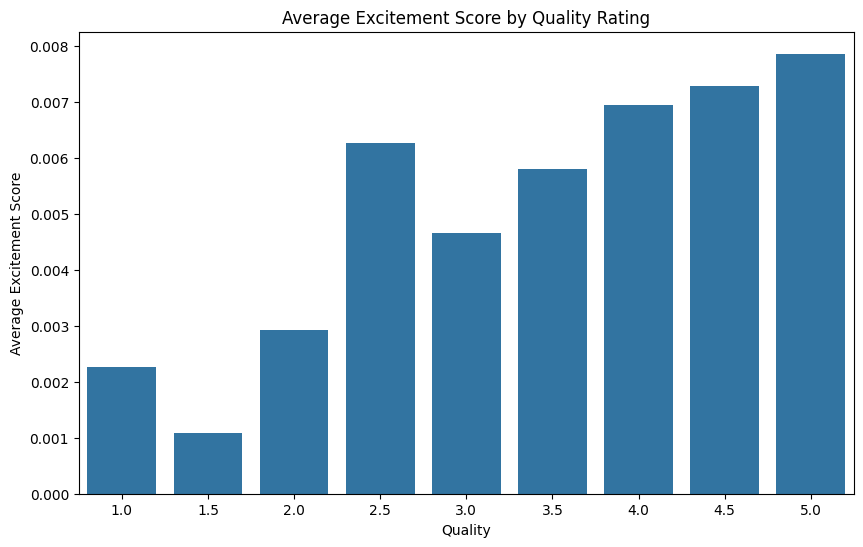

ANOVA Table for nervousness based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.000129     4.0  1.407264  0.228702
Residual       0.228511  9996.0       NaN       NaN

Regression Summary for nervousness based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:            nervousness   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.407
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.229
Time:                        23:46:42   Log-Likelihood:                 39248.
No. Observations:               10001   AIC:                        -7.849e+04
Df Residuals:                    9996   BIC:                        -7.845e+04
Df Model:                           4                                         
Covariance Type:           

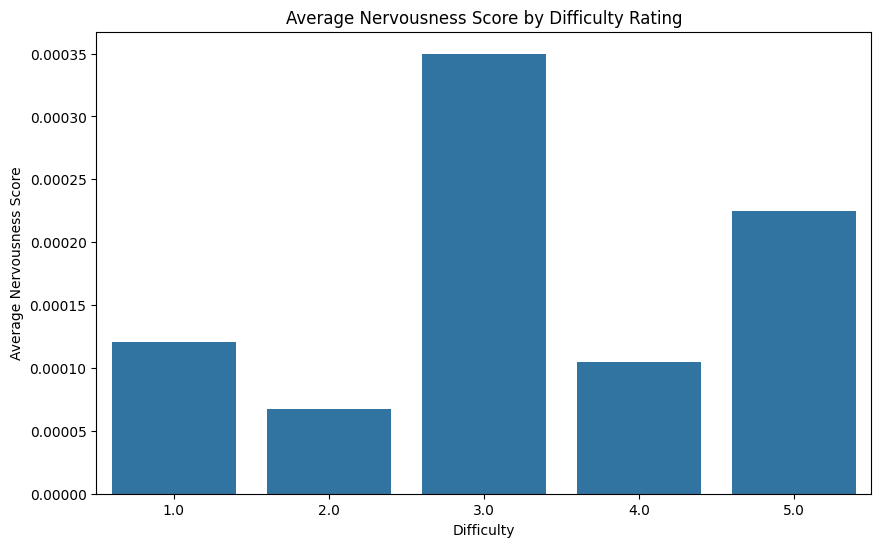

ANOVA Table for nervousness based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000101     8.0  0.551122  0.818435
Residual    0.228539  9992.0       NaN       NaN

Regression Summary for nervousness based on Quality:
                            OLS Regression Results                            
Dep. Variable:            nervousness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5511
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.818
Time:                        23:46:42   Log-Likelihood:                 39247.
No. Observations:               10001   AIC:                        -7.848e+04
Df Residuals:                    9992   BIC:                        -7.841e+04
Df Model:                           8                                         
Covariance Type:            nonrobust     

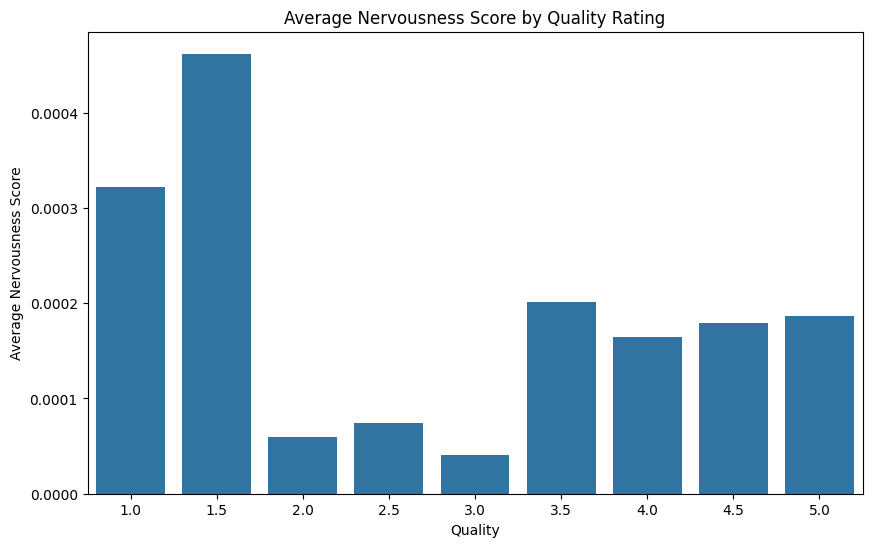

ANOVA Table for fear based on Difficulty:
                  sum_sq      df         F        PR(>F)
C(Difficulty)   0.079389     4.0  9.082014  2.551271e-07
Residual       21.844543  9996.0       NaN           NaN

Regression Summary for fear based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                   fear   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.082
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           2.55e-07
Time:                        23:46:43   Log-Likelihood:                 16445.
No. Observations:               10001   AIC:                        -3.288e+04
Df Residuals:                    9996   BIC:                        -3.284e+04
Df Model:                           4                                         
Covariance Type:          

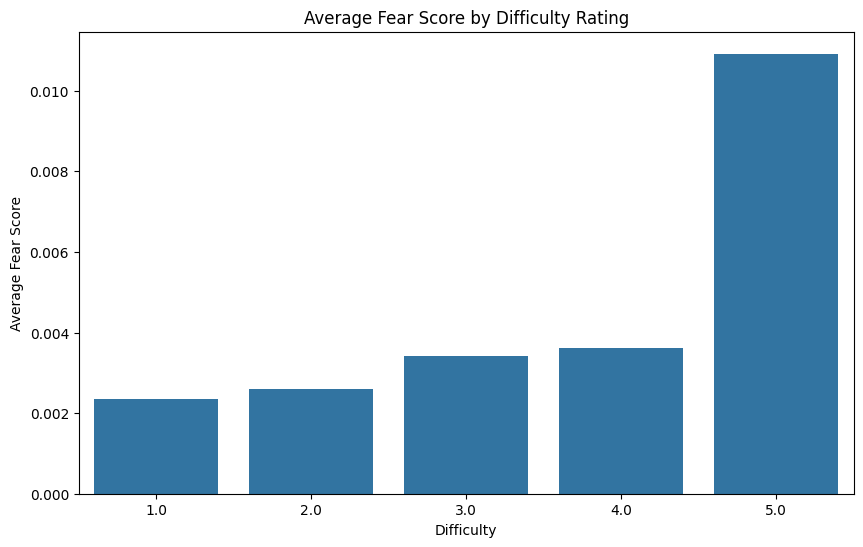

ANOVA Table for fear based on Quality:
               sum_sq      df          F        PR(>F)
C(Quality)   0.176582     8.0  10.141484  3.329532e-14
Residual    21.747350  9992.0        NaN           NaN

Regression Summary for fear based on Quality:
                            OLS Regression Results                            
Dep. Variable:                   fear   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     10.14
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           3.33e-14
Time:                        23:46:43   Log-Likelihood:                 16467.
No. Observations:               10001   AIC:                        -3.292e+04
Df Residuals:                    9992   BIC:                        -3.285e+04
Df Model:                           8                                         
Covariance Type:            nonrobust 

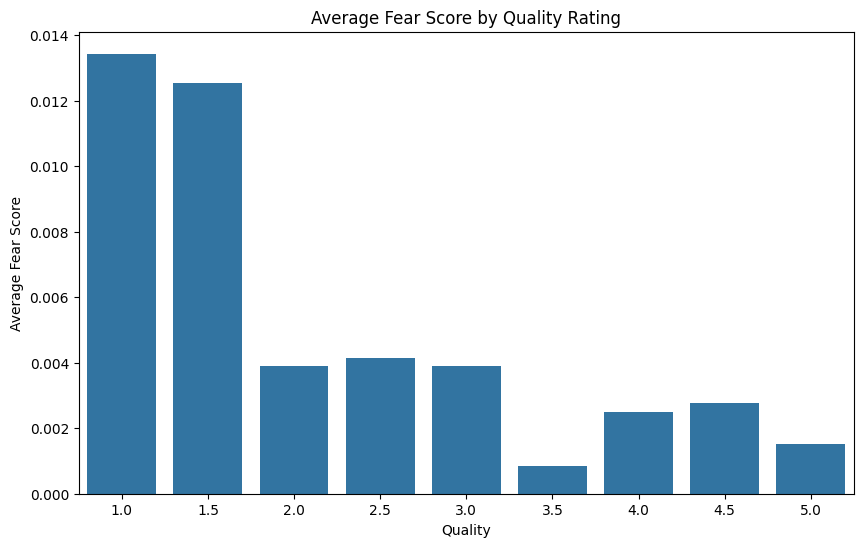

ANOVA Table for embarrassment based on Difficulty:
                 sum_sq      df        F    PR(>F)
C(Difficulty)  0.001035     4.0  1.20599  0.305915
Residual       2.144592  9996.0      NaN       NaN

Regression Summary for embarrassment based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:          embarrassment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.206
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.306
Time:                        23:46:43   Log-Likelihood:                 28051.
No. Observations:               10001   AIC:                        -5.609e+04
Df Residuals:                    9996   BIC:                        -5.606e+04
Df Model:                           4                                         
Covariance Type:          

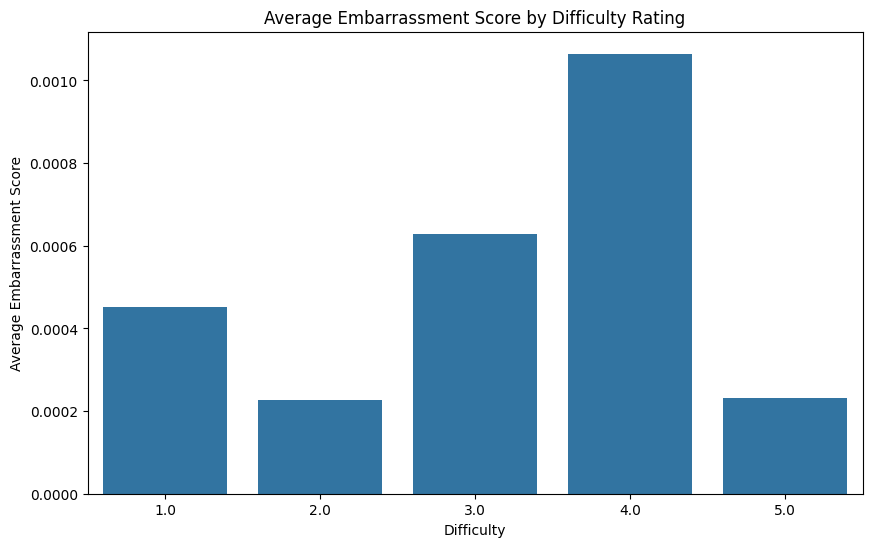

ANOVA Table for embarrassment based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.002657     8.0  1.548321  0.134932
Residual    2.142970  9992.0       NaN       NaN

Regression Summary for embarrassment based on Quality:
                            OLS Regression Results                            
Dep. Variable:          embarrassment   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.548
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.135
Time:                        23:46:44   Log-Likelihood:                 28055.
No. Observations:               10001   AIC:                        -5.609e+04
Df Residuals:                    9992   BIC:                        -5.603e+04
Df Model:                           8                                         
Covariance Type:            nonrobust 

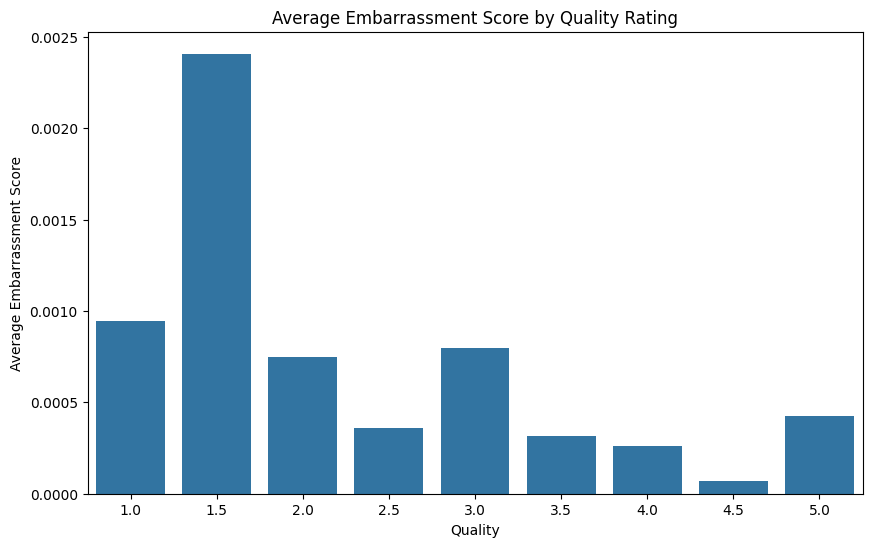

ANOVA Table for curiosity based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.004277     4.0  1.822211  0.121481
Residual       5.865194  9996.0       NaN       NaN

Regression Summary for curiosity based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              curiosity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.822
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.121
Time:                        23:46:44   Log-Likelihood:                 23020.
No. Observations:               10001   AIC:                        -4.603e+04
Df Residuals:                    9996   BIC:                        -4.599e+04
Df Model:                           4                                         
Covariance Type:            non

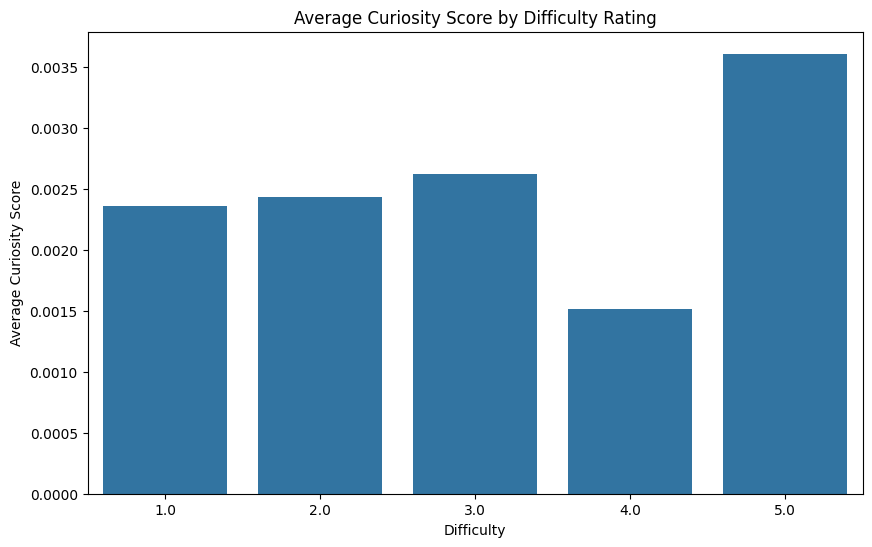

ANOVA Table for curiosity based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.004949     8.0  1.053999  0.392543
Residual    5.864522  9992.0       NaN       NaN

Regression Summary for curiosity based on Quality:
                            OLS Regression Results                            
Dep. Variable:              curiosity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.054
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.393
Time:                        23:46:44   Log-Likelihood:                 23021.
No. Observations:               10001   AIC:                        -4.602e+04
Df Residuals:                    9992   BIC:                        -4.596e+04
Df Model:                           8                                         
Covariance Type:            nonrobust         

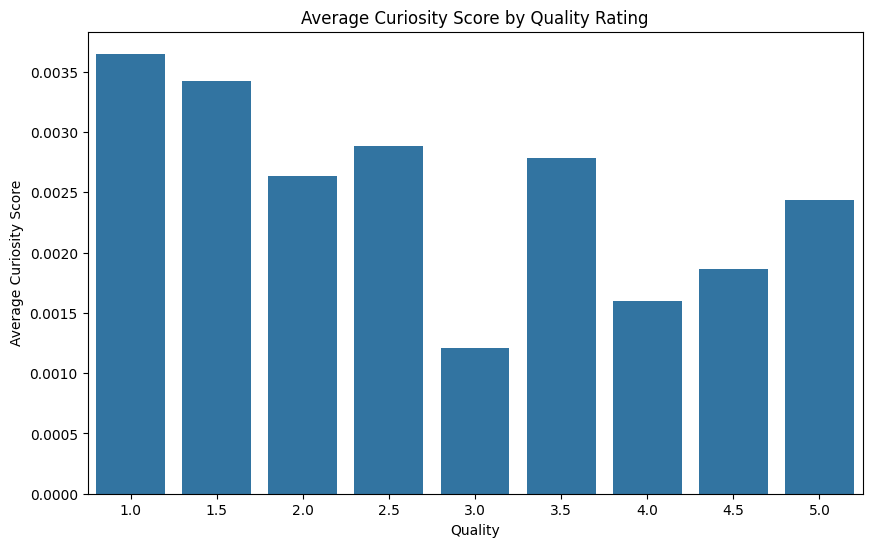

ANOVA Table for pride based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.000036     4.0  0.884881  0.471936
Residual       0.100523  9996.0       NaN       NaN

Regression Summary for pride based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                  pride   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8849
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.472
Time:                        23:46:45   Log-Likelihood:                 43354.
No. Observations:               10001   AIC:                        -8.670e+04
Df Residuals:                    9996   BIC:                        -8.666e+04
Df Model:                           4                                         
Covariance Type:            nonrobust  

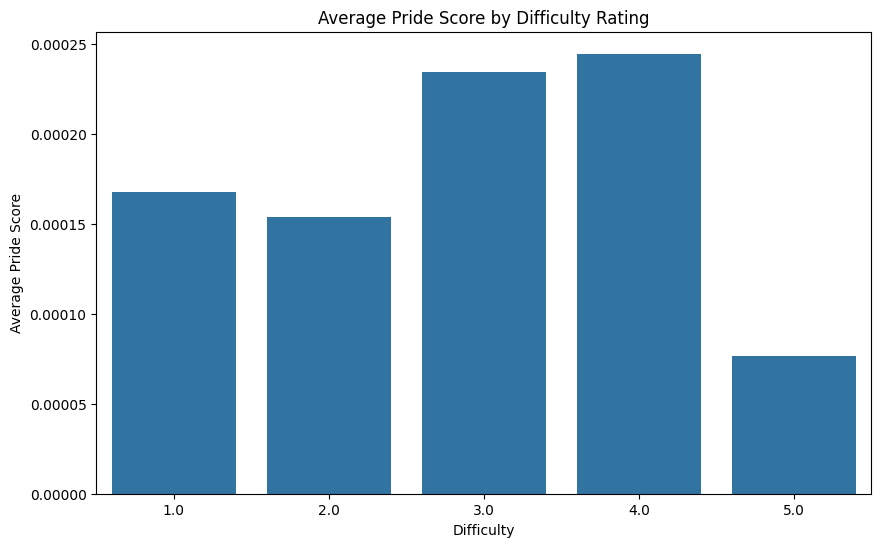

ANOVA Table for pride based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000196     8.0  2.439948  0.012374
Residual    0.100362  9992.0       NaN       NaN

Regression Summary for pride based on Quality:
                            OLS Regression Results                            
Dep. Variable:                  pride   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.440
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0124
Time:                        23:46:45   Log-Likelihood:                 43362.
No. Observations:               10001   AIC:                        -8.671e+04
Df Residuals:                    9992   BIC:                        -8.664e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                 

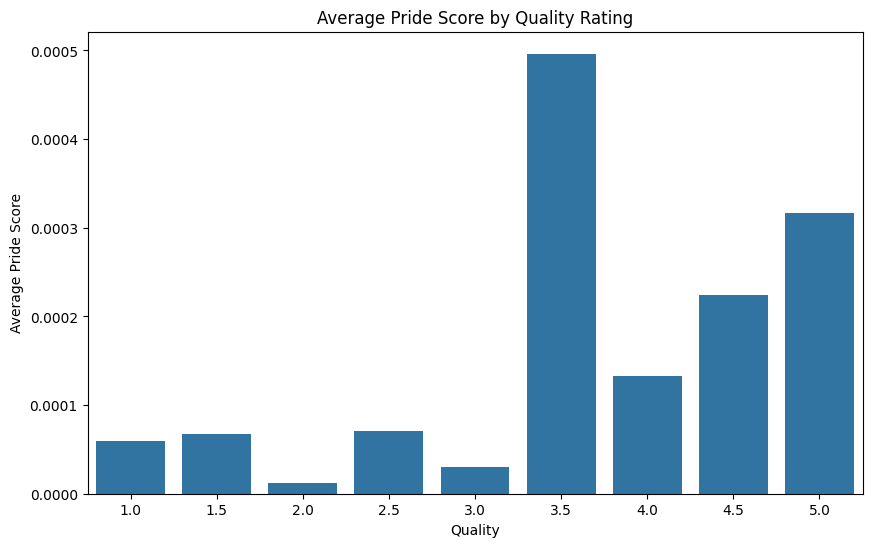

ANOVA Table for surprise based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.006213     4.0  1.470302  0.208286
Residual       10.559800  9996.0       NaN       NaN

Regression Summary for surprise based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:               surprise   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.470
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.208
Time:                        23:46:46   Log-Likelihood:                 20080.
No. Observations:               10001   AIC:                        -4.015e+04
Df Residuals:                    9996   BIC:                        -4.011e+04
Df Model:                           4                                         
Covariance Type:            no

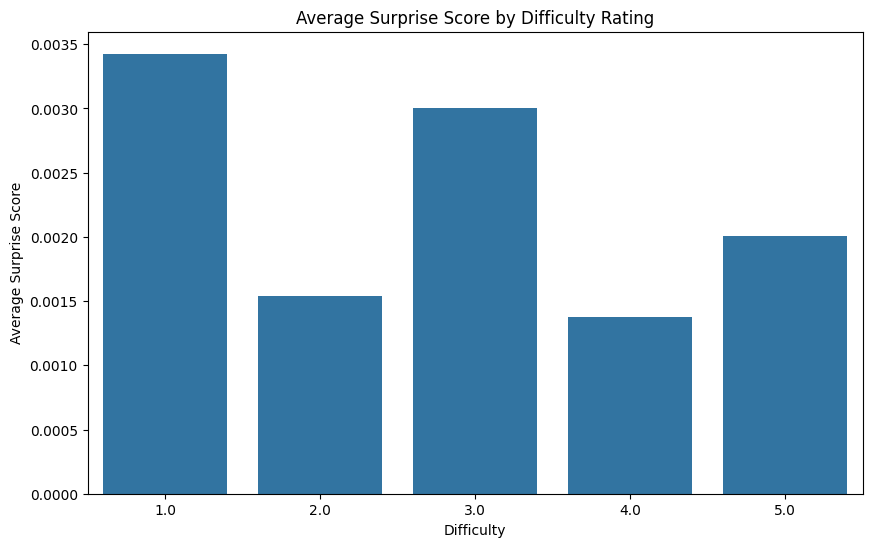

ANOVA Table for surprise based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.015776     8.0  1.867708  0.060422
Residual    10.550236  9992.0       NaN       NaN

Regression Summary for surprise based on Quality:
                            OLS Regression Results                            
Dep. Variable:               surprise   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.868
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0604
Time:                        23:46:46   Log-Likelihood:                 20084.
No. Observations:               10001   AIC:                        -4.015e+04
Df Residuals:                    9992   BIC:                        -4.009e+04
Df Model:                           8                                         
Covariance Type:            nonrobust        

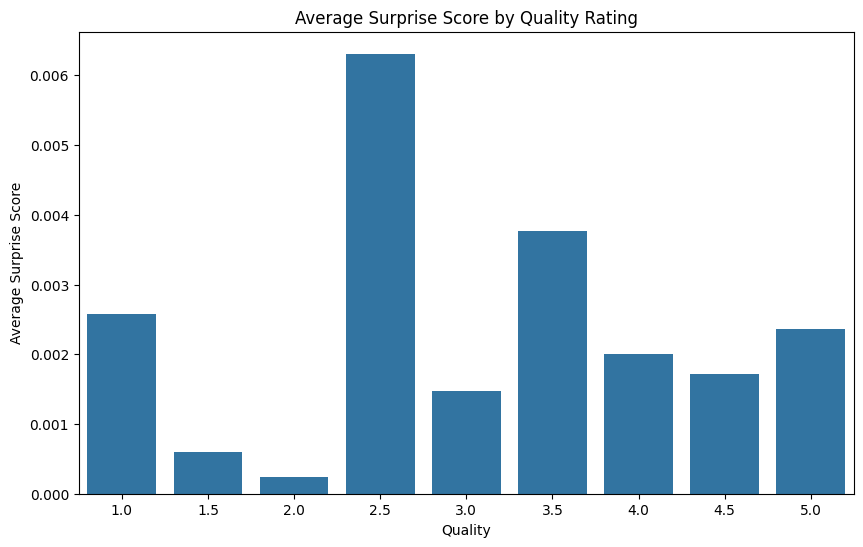

ANOVA Table for grief based on Difficulty:
                 sum_sq      df         F   PR(>F)
C(Difficulty)  0.000003     4.0  1.218116  0.30071
Residual       0.006412  9996.0       NaN      NaN

Regression Summary for grief based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                  grief   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.218
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.301
Time:                        23:46:46   Log-Likelihood:                 57116.
No. Observations:               10001   AIC:                        -1.142e+05
Df Residuals:                    9996   BIC:                        -1.142e+05
Df Model:                           4                                         
Covariance Type:            nonrobust     

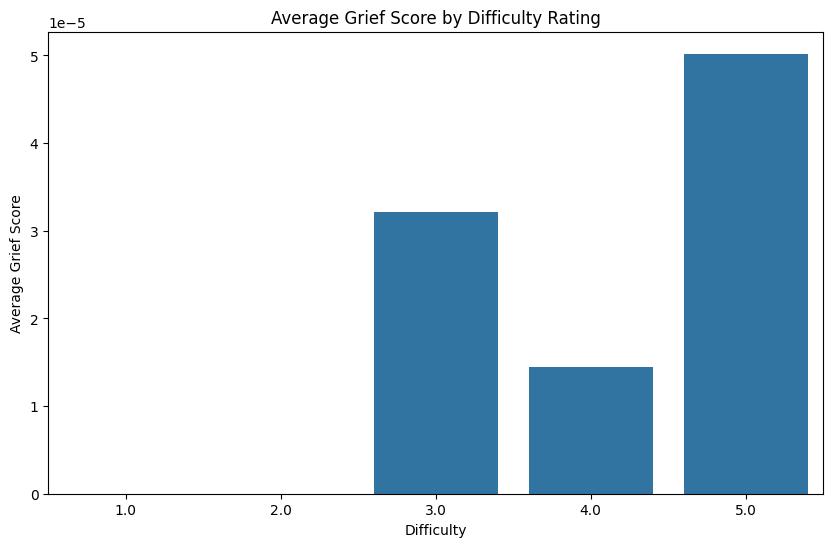

ANOVA Table for grief based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000010     8.0  1.918001  0.052917
Residual    0.006405  9992.0       NaN       NaN

Regression Summary for grief based on Quality:
                            OLS Regression Results                            
Dep. Variable:                  grief   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.918
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0529
Time:                        23:46:46   Log-Likelihood:                 57122.
No. Observations:               10001   AIC:                        -1.142e+05
Df Residuals:                    9992   BIC:                        -1.142e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                 

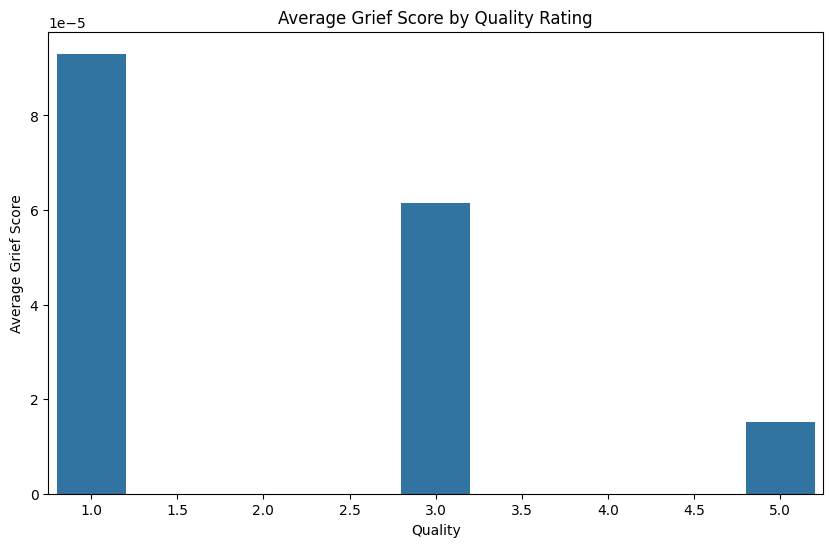

In [3]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    emotion_scores = []
    for output in outputs:
        score_dict = {label['label']: label['score'] for label in output}
        emotion_scores.append(score_dict)
    return emotion_scores

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

all_emotion_scores = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_scores = future.result()
        all_emotion_scores.extend(batch_emotion_scores)

# Create a DataFrame with emotion scores
emotion_scores_df = pd.DataFrame(all_emotion_scores)

# Add difficulty and quality ratings to the DataFrame
cmv_df = cmv_df.dropna(subset=['Review-Body']).reset_index(drop=True)
emotion_scores_df['Difficulty'] = cmv_df['Difficulty']
emotion_scores_df['Quality'] = cmv_df['Quality']

# Function to analyze emotions and plot graphs
def analyze_emotion(emotion, rating_type):
    emotion_scores_df[emotion] = emotion_scores_df[emotion].fillna(0)
    model = ols(f'{emotion} ~ C({rating_type})', data=emotion_scores_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"ANOVA Table for {emotion} based on {rating_type}:")
    print(anova_table)

    print(f"\nRegression Summary for {emotion} based on {rating_type}:")
    print(model.summary())

    # Aggregate emotion scores by rating
    avg_emotion_by_rating = emotion_scores_df.groupby(rating_type)[emotion].mean().reset_index()

    print(f"\nAverage {emotion.capitalize()} Score by {rating_type.capitalize()} Rating:")
    print(avg_emotion_by_rating)
    print("\n" + "="*80 + "\n")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rating_type, y=emotion, data=avg_emotion_by_rating)
    plt.title(f'Average {emotion.capitalize()} Score by {rating_type.capitalize()} Rating')
    plt.xlabel(rating_type.capitalize())
    plt.ylabel(f'Average {emotion.capitalize()} Score')
    plt.show()

# List of emotions to analyze
emotions = emotion_scores_df.columns[:-2]  # Exclude 'Difficulty' and 'Quality' columns

# Analyze each emotion for difficulty and quality
for emotion in emotions:
    analyze_emotion(emotion, 'Difficulty')
    analyze_emotion(emotion, 'Quality')
